In [1]:
import pandas as pd
import numpy as np
import re
import os
import nltk
import pymorphy2
import json
import random
import matplotlib.pyplot as plt
import copy
import itertools

from os.path import join, isdir, isfile
from os import mkdir
from sklearn.model_selection import StratifiedShuffleSplit
from fasttext import load_model
from tqdm import tqdm
from matplotlib import rc
from typing import Generator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from fasttext import load_model


#visualization
%matplotlib inline
morph = pymorphy2.MorphAnalyzer()

## Разделение данных

In [7]:
def read_dataset(filepath, duplicates=False, clean=True):
    file = open(filepath, 'r', encoding='ISO-8859-1')
    data = pd.read_csv(file)

    old_names = data.keys()
    names = [n.encode('ISO-8859-1').decode('cp1251').encode('utf8') for n in old_names]
    names = [n.decode('utf-8') for n in names]

    new_data = dict()
    for old, new in zip(old_names, names):
        new_data[new] = list()
        for c in data[old]:
            try:
                s = c.encode('ISO-8859-1').decode('cp1251').encode('utf8')
                s = s.decode('utf-8')
                new_data[new].append(s)
            except AttributeError:
                new_data[new].append(c)

    new_data = pd.DataFrame(new_data, columns=['Описание', 'Категория жалобы'])
    new_data.rename(columns={'Описание': 'request', 'Категория жалобы': 'class'}, inplace=True)
    new_data = new_data.dropna()  # dell nan
    if not duplicates:
        new_data = new_data.drop_duplicates()  # dell duplicates

    # как отдельную ветвь можно использовать
    if clean:
        delete_bad_symbols = lambda x: " ".join(re.sub('[^а-яa-zё0-9]', ' ', x.lower()).split())
        new_data['request'] = new_data['request'].apply(delete_bad_symbols)

    new_data = new_data.reset_index()
    new_data = new_data.drop('index', axis=1)

    return new_data

/home/mks/envs/intent_script/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (6,7,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


{1: 3288, 2: 5312, 3: 6791, 4: 1366, 5: 80, 6: 9600, 7: 3634, 8: 442, 9: 906, 10: 3501, 11: 2039, 12: 2287, 13: 3568, 14: 205, 15: 1188, 16: 922, 17: 42}


2018-03-14 20:10:01.912 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1354: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/mks/intent/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-03-14 20:10:01.976 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1354: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/mks/intent/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


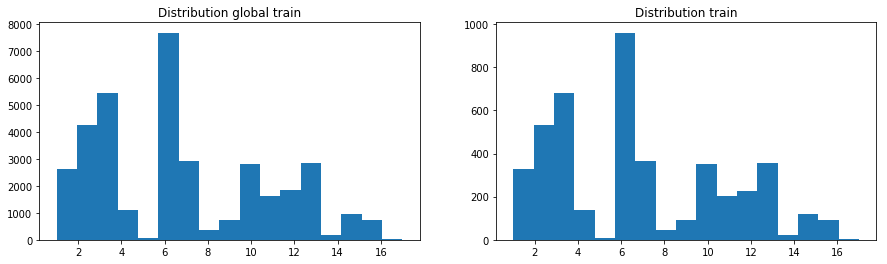

In [8]:
dd = dict()
cd = dict()
path = './data/vkusvill_all_categories.csv'
global_data = read_dataset(path)

for x, y in zip(global_data['request'], global_data['class']):
    if y not in dd.keys():
        dd[y] = list()
        cd[y] = 0
        dd[y].append((x, y))
        cd[y] += 1
    else:
        dd[y].append((x, y))
        cd[y] += 1

# print(dd[1])
print(cd)

prop = [0.1, 0.1]

if type(prop) is list:
    assert len(prop) == 2
    assert type(prop[0]) is float

    valid_ = dict()
    test_ = dict()

    for x in dd.keys():
        num = int(cd[x]*prop[0])
        valid_[x] = random.sample(dd[x], num)
        [dd[x].remove(t) for t in valid_[x]]

    for x in dd.keys():
        num = int(cd[x]*prop[1])
        test_[x] = random.sample(dd[x], num)
        [dd[x].remove(t) for t in test_[x]]
else:
    raise ValueError('Split proportion must be list of floats, with length = 2')

train_ = dd

train, valid, test = list(), list(), list()


for x in train_.keys():
    for z_, z in zip([train_, valid_, test_], [train, valid, test]):
        z.extend(z_[x])

del train_, valid_, test_, dd

for z in [train, valid, test]:
    z = random.shuffle(z)
    

utrain, uvalid, utest, ctrain, cvalid, ctest = list(), list(), list(), list(), list(), list()

for z, n, c in zip([train, valid, test], [utrain, uvalid, utest], [ctrain, cvalid, ctest]):
    for x in z:
        n.append(x[0])
        c.append(x[1])
        
train = pd.DataFrame({'request': utrain,
                     'class': ctrain})
valid = pd.DataFrame({'request': uvalid,
                     'class': cvalid})
test = pd.DataFrame({'request': utest,
                     'class': ctest})

fig, ax = plt.subplots()
fig.set_figwidth(15)

plt.subplot(1, 2, 1)
plt.title('Distribution global train')
plt.hist(train['class'], bins=17)  # 70

plt.subplot(1, 2, 2)
plt.title('Distribution train')
plt.hist(test['class'], bins=17)  # 70
plt.show()

## Отработка препроцессинга в классе pipeline

In [9]:
class Dataset(object):
    def __init__(self, data, seed=None, split=True, splitting_proportions=None,
                 *args, **kwargs):

        rs = random.getstate()
        random.seed(seed)
        self.random_state = random.getstate()
        random.setstate(rs)

        if splitting_proportions is None:
            self.splitting_proportions = [0.1, 0.1]
        else:
            self.splitting_proportions = splitting_proportions

        if not split:
            self.train = data.get('train', [])
            self.test = data.get('test', [])
            try:
                self.valid = data.get('valid', [])
                self.data = {'train': {'base': self.train},
                             'test': {'base': self.test},
                             'valid': {'base': self.valid},
                             'all': {'base': self.train + self.test}}
            except KeyError:
                self.data = {'train': {'base': self.train},
                             'test': {'base': self.test},
                             'all': {'base': self.train + self.test}}
        else:
            self.train, self.valid, self.test = self.split_data(data)
            self.data = {'train': {'base': self.train},
                         'test': {'base': self.test},
                         'valid': {'base': self.valid},
                         'all': {'base': self.train + self.test}}

        self.data['classes'] = data['class'].unique()  # np.array

    def batch_generator(self, batch_size: int, data_type: str = 'train', stage: str = 'base') -> Generator:
        r"""This function returns a generator, which serves for generation of raw (no preprocessing such as tokenization)
         batches
        Args:
            batch_size (int): number of samples in batch
            data_type (str): can be either 'train', 'test', or 'valid'
        Returns:
            batch_gen (Generator): a generator, that iterates through the part (defined by data_type) of the dataset
        """
        data = self.data[data_type][stage]
        data_len = len(data)
        order = list(range(data_len))

        rs = random.getstate()
        random.setstate(self.random_state)
        random.shuffle(order)
        self.random_state = random.getstate()
        random.setstate(rs)

        # for i in range((data_len - 1) // batch_size + 1):
        #     yield list(zip(*[data[o] for o in order[i * batch_size:(i + 1) * batch_size]]))
        for i in range((data_len - 1) // batch_size + 1):
            o = order[i * batch_size:(i + 1) * batch_size]
            yield list((list(data['request'][o]), list(data['class'][o])))

    def iter_all(self, data_type: str = 'train', stage: str = 'base') -> Generator:
        """
        Iterate through all data. It can be used for building dictionary or
        Args:
            data_type (str): can be either 'train', 'test', or 'valid'
        Returns:
            samples_gen: a generator, that iterates through the all samples in the selected data type of the dataset
        """
        data = self.data[data_type][stage]
        for x, y in zip(data['request'], data['class']):
            yield (x, y)

    def _split_data(self, splitting_proportions, field_to_split, splitted_fields):
        data_to_div = self.data[field_to_split].copy()
        data_size = len(self.data[field_to_split])
        for i in range(len(splitted_fields) - 1):
            self.data[splitted_fields[i]], data_to_div = train_test_split(data_to_div,
                                                                          test_size=
                                                                          len(data_to_div) -
                                                                          int(data_size * splitting_proportions[i]))
        self.data[splitted_fields[-1]] = data_to_div
        return True

    def split_data(self, dataset):

        dd = dict()
        cd = dict()
        train = list()
        valid = list()
        test = list()

        for x, y in zip(dataset['request'], dataset['class']):
            if y not in dd.keys():
                dd[y] = list()
                cd[y] = 0
                dd[y].append((x, y))
                cd[y] += 1
            else:
                dd[y].append((x, y))
                cd[y] += 1

        if type(self.splitting_proportions) is list:
            assert len(self.splitting_proportions) == 2
            assert type(self.splitting_proportions[0]) is float

            valid_ = dict()
            test_ = dict()

            for x in dd.keys():
                num = int(cd[x] * self.splitting_proportions[0])
                valid_[x] = random.sample(dd[x], num)
                [dd[x].remove(t) for t in valid_[x]]

            for x in dd.keys():
                num = int(cd[x] * self.splitting_proportions[1])
                test_[x] = random.sample(dd[x], num)
                [dd[x].remove(t) for t in test_[x]]
        else:
            raise ValueError('Split proportion must be list of floats, with length = 2')

        train_ = dd

        for x in train_.keys():
            for z_, z in zip([train_, valid_, test_], [train, valid, test]):
                z.extend(z_[x])

        del train_, valid_, test_, dd, cd, dataset  # really need ?

        for z in [train, valid, test]:
            z = random.shuffle(z)

        utrain, uvalid, utest, ctrain, cvalid, ctest = list(), list(), list(), list(), list(), list()
        for z, n, c in zip([train, valid, test], [utrain, uvalid, utest], [ctrain, cvalid, ctest]):
            for x in z:
                n.append(x[0])
                c.append(x[1])

        train = pd.DataFrame({'request': utrain,
                              'class': ctrain})
        valid = pd.DataFrame({'request': uvalid,
                              'class': cvalid})
        test = pd.DataFrame({'request': utest,
                             'class': ctest})

        return train, valid, test

    def _merge_data(self, fields_to_merge):
        data = self.data.copy()
        new_name = [s + '_' for s in fields_to_merge]
        data[new_name] = []
        for name in fields_to_merge:
            data[new_name] += self.data[name]
        self.data = data
        return True


In [10]:
# path = './data/vkusvill_all_categories.csv'
# global_data = read_dataset(path)

dataset = Dataset(global_data, seed=42)
print(dataset.data['classes'])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


### Transformation 

In [8]:
def transform(data, lower=True, lemma=True, ngramm=False):
    Tokens = list()
    for x in tqdm(data['request']):
        sent_toks = nltk.sent_tokenize(x)
        word_toks = [nltk.word_tokenize(el) for el in sent_toks]
        tokens = [val for sublist in word_toks for val in sublist]
        tokens = [el for el in tokens if el != '']
        if lower:
            tokens = [el.lower() for el in tokens]
        if lemma:
            tokens = [morph.parse(el)[0].normal_form for el in tokens]
        if ngramm:
            bigram = list(nltk.bigrams(tokens))
            bigram = ['_'.join(x) for x in bigram]
            tokens.extend(bigram)

        Tokens.append(' '.join(tokens))
    
    df = pd.DataFrame({'request': Tokens,
                       'class': data['class']})
    return df

In [9]:
dataset.data['test']['mod'] = transform(dataset.data['test']['base'])

100%|██████████| 4510/4510 [00:28<00:00, 157.56it/s]


In [10]:
dataset.data['test']['mod']['request'][0]
# b = list(nltk.bigrams(dataset.data['test']['base']['request'][0].split()))
# c = ['_'.join([x[0], x[1]]) for x in b]
# print(c)

'добрый вечер попробовать два сэндвич ролл цезарь с курица с кетой в цезар очень сухой курица соус стоить бы полить на кусочек филе а не мазать где то сбоку потому что один край получаться вкусный в два очень трудно жевать да и вкус не ахти как много ощущаться быть переодичёска покупать но быть бы очень признательный если б к мой комментарий прислушаться с кетой вообще ужас красный рыба я любить но не в это случай филе много очень солёный себя пропитывать весь остальной составлять рикотт в самый хвост лаваш испортить весь совсем даже половина половинка не съесть прийтись нести на возврат завтра а ведь купить сразу два упаковка'

### Vectorization

In [11]:
cvec = CountVectorizer(min_df=5)
tfvec = TfidfVectorizer()
fast = load_model('/home/mks/projects/intent_classification_script/embeddings/ft_0.8.3_nltk_yalen_sg_300.bin')

In [10]:
# vec = cvec.fit_transform(dataset.data['test']['mod1']['request'])
# print(type(vec), vec)

In [11]:
# vec = tfvec.fit_transform(dataset.data['test']['mod1']['request'])
# print(type(vec), vec)

In [93]:
config = {'lemma': True,
          'lower': True,
          'n-gram': False,
          'vectorization': {'count': False,
                            'tf-idf': False,
                            'fasttext': True},
          'model': {'name': 'CNN', 'model_config': None},
          'fasttext_model': '/home/mks/projects/intent_classification_script/embeddings/ft_0.8.3_nltk_yalen_sg_300.bin'}

opt = {'text_size': 25, 'embedding_size': 300}

# vectorizers
if config['vectorization']['count']:
    vectorizer = CountVectorizer(min_df=5)  # tokenizer=self.tokenizer,
    config['tokenization'] = False
elif config['vectorization']['tf-idf']:
    vectorizer = TfidfVectorizer()  # tokenizer=self.tokenizer
    config['tokenization'] = False
elif config['vectorization']['fasttext']:
    vectorizer = load_model(config['fasttext_model'])
    config['tokenization'] = True
else:
    raise NotImplementedError('Not implemented vectorizer.')


def vectorization(data, train=False):
    # vectorization
    if not config['tokenization']:
        if train:
            vec = vectorizer.fit_transform(data)
        else:
            vec = vectorizer.transform(data)
    else:
        data = tokenize(data)
        if config['model']['name'] == 'CNN':
            vec = np.zeros((len(data), opt['text_size'], opt['embedding_size']))
            for j, x in enumerate(data):
                for i, y in enumerate(x):
                    if i < opt['text_size']:
                        vec[j, i] = vectorizer[y]
                    else:
                        break
        else:
            raise NotImplementedError()

    return vec

In [13]:
def tokenize(data):
    tok_data = list()
    for x in data:
        sent_toks = nltk.sent_tokenize(x)
        word_toks = [nltk.word_tokenize(el) for el in sent_toks]
        tokens = [val for sublist in word_toks for val in sublist]
        tok_data.append(tokens)
    
    return tok_data

In [14]:
vec = vectorization(dataset.data['test']['mod']['request'], train=True)
print(type(vec))

<class 'numpy.ndarray'>


In [22]:
print(vec.shape)

(4510, 25, 300)


# Тестирование CNN модели

In [89]:
import keras.metrics
import keras.optimizers
import tensorflow as tf

from pathlib import Path
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Dense, Input, concatenate, Activation
from keras.layers.pooling import GlobalMaxPooling1D, MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from models.CNN import metrics as metrics_file
from utils import labels2onehot, log_metrics, labels2onehot_one, tokenize

from os.path import isdir
import os

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = '0'
set_session(tf.Session(config=config))


class KerasMulticlassModel(object):
    """
    Class builds keras intent_model
    """

    def __init__(self, opt, vectorizer, *args, **kwargs):
        """
        Method initializes intent_model using parameters from opt
        Args:
            opt: dictionary of parameters
            *args:
            **kwargs:
        """
        self.opt = copy.deepcopy(opt)
        self.vectorizer = vectorizer

        self.model_path_ = Path(self.opt["model_path"])
        self.confident_threshold = self.opt['confident_threshold']

        if self.opt['model_from_saved']:
            self.model = self.load(model_name=self.opt['model_name'],
                                   fname=self.model_path_,
                                   optimizer_name=self.opt['optimizer'],
                                   lr=self.opt['lear_rate'],
                                   decay=self.opt['lear_rate_decay'],
                                   loss_name=self.opt['loss'],
                                   metrics_names=self.opt['lear_metrics'],
                                   add_metrics_file=metrics_file)
        else:
            self.classes = np.array(self.opt['classes'].split(' '))
            self.n_classes = self.classes.shape[0]
            self.model = self.init_model_from_scratch(model_name=self.opt['model_name'],
                                                      optimizer_name=self.opt['optimizer'],
                                                      lr=self.opt['lear_rate'],
                                                      decay=self.opt['lear_rate_decay'],
                                                      loss_name=self.opt['loss'],
                                                      metrics_names=self.opt['lear_metrics'],
                                                      add_metrics_file=metrics_file)

        self.metrics_names = self.model.metrics_names
        self.metrics_values = len(self.metrics_names) * [0.]

    # vectorization
    def texts2vec(self, data):
        data = tokenize(data)
        vec = np.zeros((len(data), self.opt['text_size'], self.opt['embedding_size']))
        for j, x in enumerate(data):
            for i, y in enumerate(x):
                if i < self.opt['text_size']:
                    vec[j, i] = self.vectorizer[y]
                else:
                    break

        return vec

    def train_on_batch(self, batch):
        """
        Method trains the intent_model on the given batch
        Args:
            batch - list of tuples (preprocessed text, labels)

        Returns:
            loss and metrics values on the given batch
        """

        features = batch[0]
        labels = batch[1]
        onehot_labels = labels2onehot_one(labels, classes=self.classes)
        metrics_values = self.model.train_on_batch(features, onehot_labels)
        return metrics_values

    def fit(self, dataset, stage='base', *args, **kwargs):
        """
        Method trains the intent_model using batches and validation
        Args:
            dataset: instance of class Dataset
            stage:
        Returns: None
        """
        updates = 0
        val_loss = 1e100
        val_increase = 0
        epochs_done = 0

        valid_iter_all = dataset.iter_all(data_type='valid', stage=stage)
        valid_x = []
        valid_y = []
        for valid_i, valid_sample in enumerate(valid_iter_all):
            valid_x.append(valid_sample[0])
            valid_y.append(valid_sample[1])

        valid_x = self.texts2vec(valid_x)
        # valid_y = labels2onehot_one(valid_y, self.opt['classes'])
        valid_y = labels2onehot_one(valid_y, self.classes)

        # print('\n____Training over {} samples____\n\n'.format(n_train_samples))

        while epochs_done < self.opt['epochs']:
            batch_gen = dataset.batch_generator(batch_size=self.opt['batch_size'],
                                                data_type='train', stage=stage)
            for step, batch in enumerate(batch_gen):
                vec = self.texts2vec(batch[0])
                batch_ = [vec, batch[1]]
                metrics_values = self.train_on_batch(batch_)
                updates += 1

                if self.opt['verbose'] and step % 50 == 0:
                    log_metrics(names=self.metrics_names,
                                values=metrics_values,
                                updates=updates,
                                mode='train')

            epochs_done += 1
            if epochs_done % self.opt['val_every_n_epochs'] == 0:
                print('Epoch: {}'.format(epochs_done))
                if 'valid' in dataset.data.keys():
                    valid_metrics_values = self.model.test_on_batch(x=valid_x, y=valid_y)

                    log_metrics(names=self.metrics_names,
                                values=valid_metrics_values,
                                mode='valid')
                    if valid_metrics_values[0] > val_loss:
                        val_increase += 1
                        # print("__Validation impatience {} out of {}".format(
                        #     val_increase, self.opt['val_patience']))
                        if val_increase == self.opt['val_patience']:
                            # print("___Stop training: validation is out of patience___")
                            break
                    else:
                        val_increase = 0
                        val_loss = valid_metrics_values[0]
                        # print('epochs_done: {}'.format(epochs_done))

        self.save(self.opt['model_name'])

    def test(self, dataset, stage='base', *args, **kwargs):
        """
        Method trains the intent_model using batches and validation
        Args:
            dataset: instance of class Dataset
            stage:
        Returns: None
        """

        valid_iter_all = dataset.iter_all(data_type='test', stage=stage)
        valid_x = []
        valid_y = []

        for valid_i, valid_sample in enumerate(valid_iter_all):
            valid_x.append(valid_sample[0])
            valid_y.append(valid_sample[1])

        valid_x = self.texts2vec(valid_x)
        y_test = np.array(valid_y)
        valid_y = labels2onehot_one(valid_y, self.classes)

        # print('\n____Testing over {} samples____\n\n'.format(n_train_samples))

        if 'test' in dataset.data.keys():
            valid_metrics_values = self.model.test_on_batch(x=valid_x, y=valid_y)
            log_metrics(names=self.metrics_names,
                        values=valid_metrics_values,
                        mode='test')
            
            prediction = self.model.predict(valid_x)
            y_pred = prediction.argmax(axis=1)
            y_pred = np.array([x + 1 for x in y_pred])
            results = get_result(y_pred, y_test)
        else:
            raise ValueError('In dataset absent {} part of data'.format('test'))

        return results

    def infer(self, data, *args):
        """
        Method returns predictions on the given data
        Args:
            data: sentence or list of sentences
            *args:

        Returns:
            Predictions for the given data
        """
        if type(data) is str:
            features = self.texts2vec([data])
            preds = self.model.predict_on_batch(features)[0]
        else:
            features = self.texts2vec(data)
            preds = self.model.predict_on_batch(features)
        return preds

    def cnn_model(self, params):
        """
        Method builds uncompiled intent_model of shallow-and-wide CNN
        Args:
            params: disctionary of parameters for NN

        Returns:
            Uncompiled intent_model
        """
        if type(self.opt['kernel_sizes_cnn']) is str:
            self.opt['kernel_sizes_cnn'] = [int(x) for x in
                                            self.opt['kernel_sizes_cnn'].split(' ')]

        inp = Input(shape=(params['text_size'], params['embedding_size']))

        outputs = []
        for i in range(len(params['kernel_sizes_cnn'])):
            output_i = Conv1D(params['filters_cnn'], kernel_size=params['kernel_sizes_cnn'][i],
                              activation=None,
                              kernel_regularizer=l2(params['coef_reg_cnn']),
                              padding='same')(inp)
            output_i = BatchNormalization()(output_i)
            output_i = Activation('relu')(output_i)
            output_i = GlobalMaxPooling1D()(output_i)
            outputs.append(output_i)

        output = concatenate(outputs, axis=1)

        output = Dropout(rate=params['dropout_rate'])(output)
        output = Dense(params['dense_size'], activation=None,
                       kernel_regularizer=l2(params['coef_reg_den']))(output)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = Dropout(rate=params['dropout_rate'])(output)
        output = Dense(self.n_classes, activation=None,
                       kernel_regularizer=l2(params['coef_reg_den']))(output)
        output = BatchNormalization()(output)
        act_output = Activation(params['last_activation'])(output)
        model = Model(inputs=inp, outputs=act_output)
        return model

    def dcnn_model(self, params):
        """
        Method builds uncompiled intent_model of deep CNN
        Args:
            params: disctionary of parameters for NN

        Returns:
            Uncompiled intent_model
        """
        if type(self.opt['kernel_sizes_cnn']) is str:
            self.opt['kernel_sizes_cnn'] = [int(x) for x in
                                            self.opt['kernel_sizes_cnn'].split(' ')]

        if type(self.opt['filters_cnn']) is str:
            self.opt['filters_cnn'] = [int(x) for x in
                                       self.opt['filters_cnn'].split(' ')]

        inp = Input(shape=(params['text_size'], params['embedding_size']))

        output = inp

        for i in range(len(params['kernel_sizes_cnn'])):
            output = Conv1D(params['filters_cnn'][i], kernel_size=params['kernel_sizes_cnn'][i],
                            activation=None,
                            kernel_regularizer=l2(params['coef_reg_cnn']),
                            padding='same')(output)
            output = BatchNormalization()(output)
            output = Activation('relu')(output)
            output = MaxPooling1D()(output)

        output = GlobalMaxPooling1D()(output)
        output = Dropout(rate=params['dropout_rate'])(output)
        output = Dense(params['dense_size'], activation=None,
                       kernel_regularizer=l2(params['coef_reg_den']))(output)
        output = BatchNormalization()(output)
        output = Activation('relu')(output)
        output = Dropout(rate=params['dropout_rate'])(output)
        output = Dense(self.n_classes, activation=None,
                       kernel_regularizer=l2(params['coef_reg_den']))(output)
        output = BatchNormalization()(output)
        act_output = Activation(params['last_activation'])(output)
        model = Model(inputs=inp, outputs=act_output)
        return model

    def init_model_from_scratch(self, model_name, optimizer_name,
                                lr, decay, loss_name, metrics_names=None, add_metrics_file=None,
                                loss_weights=None,
                                sample_weight_mode=None,
                                weighted_metrics=None,
                                target_tensors=None):
        """
        Method initializes intent_model from scratch with given params
        Args:
            model_name: name of intent_model function described as a method of this class
            optimizer_name: name of optimizer from keras.optimizers
            lr: learning rate
            decay: learning rate decay
            loss_name: loss function name (from keras.losses)
            metrics_names: names of metrics (from keras.metrics) as one string
            add_metrics_file: file with additional metrics functions
            loss_weights: optional parameter as in keras.intent_model.compile
            sample_weight_mode: optional parameter as in keras.intent_model.compile
            weighted_metrics: optional parameter as in keras.intent_model.compile
            target_tensors: optional parameter as in keras.intent_model.compile

        Returns:
            compiled intent_model with given network and learning parameters
        """
        # print('[ Initializing intent_model from scratch ]')

        model_func = getattr(self, model_name, None)
        if callable(model_func):
            model = model_func(params=self.opt)
        else:
            raise AttributeError("Model {} is not defined".format(model_name))

        optimizer_func = getattr(keras.optimizers, optimizer_name, None)
        if callable(optimizer_func):
            optimizer_ = optimizer_func(lr=lr, decay=decay)
        else:
            raise AttributeError("Optimizer {} is not callable".format(optimizer_name))

        loss_func = getattr(keras.losses, loss_name, None)
        if callable(loss_func):
            loss = loss_func
        else:
            raise AttributeError("Loss {} is not defined".format(loss_name))

        metrics_names = metrics_names.split(' ')
        metrics_funcs = []
        for i in range(len(metrics_names)):
            metrics_func = getattr(keras.metrics, metrics_names[i], None)
            if callable(metrics_func):
                metrics_funcs.append(metrics_func)
            else:
                metrics_func = getattr(add_metrics_file, metrics_names[i], None)
                if callable(metrics_func):
                    metrics_funcs.append(metrics_func)
                else:
                    raise AttributeError("Metric {} is not defined".format(metrics_names[i]))

        model.compile(optimizer=optimizer_,
                      loss=loss,
                      metrics=metrics_funcs,
                      loss_weights=loss_weights,
                      sample_weight_mode=sample_weight_mode,
                      # weighted_metrics=weighted_metrics,
                      # target_tensors=target_tensors
                      )
        return model

    def load(self, model_name, fname, optimizer_name,
             lr, decay, loss_name, metrics_names=None, add_metrics_file=None, loss_weights=None,
             sample_weight_mode=None, weighted_metrics=None, target_tensors=None):
        """
        Method initiliazes intent_model from saved params and weights
        Args:
            model_name: name of intent_model function described as a method of this class
            fname: path and first part of name of intent_model
            optimizer_name: name of optimizer from keras.optimizers
            lr: learning rate
            decay: learning rate decay
            loss_name: loss function name (from keras.losses)
            metrics_names: names of metrics (from keras.metrics) as one string
            add_metrics_file: file with additional metrics functions
            loss_weights: optional parameter as in keras.intent_model.compile
            sample_weight_mode: optional parameter as in keras.intent_model.compile
            weighted_metrics: optional parameter as in keras.intent_model.compile
            target_tensors: optional parameter as in keras.intent_model.compile

        Returns:
            intent_model with loaded weights and network parameters from files
            but compiled with given learning parameters
        """
        # print('___Initializing intent_model from saved___'
        #       '\nModel weights file is %s.h5'
        #       '\nNetwork parameters are from %s_opt.json' % (fname, fname))

        fname = self.model_path_.name
        opt_fname = str(fname) + '_opt.json'
        weights_fname = str(fname) + '.h5'

        opt_path = Path.joinpath(self.model_path_, opt_fname)
        weights_path = Path.joinpath(self.model_path_, weights_fname)

        if Path(opt_path).is_file():
            with open(opt_path, 'r') as opt_file:
                self.opt = json.load(opt_file)
        else:
            raise IOError("Error: config file %s_opt.json of saved intent_model does not exist" % fname)

        self.classes = np.array(self.opt['classes'].split(" "))
        self.n_classes = self.classes.shape[0]

        model_func = getattr(self, model_name, None)
        if callable(model_func):
            model = model_func(params=self.opt)
        else:
            raise AttributeError("Model {} is not defined".format(model_name))

        # print("Loading wights from `{}`".format(fname + '.h5'))
        model.load_weights(weights_path)

        optimizer_func = getattr(keras.optimizers, optimizer_name, None)
        if callable(optimizer_func):
            optimizer_ = optimizer_func(lr=lr, decay=decay)
        else:
            raise AttributeError("Optimizer {} is not callable".format(optimizer_name))

        loss_func = getattr(keras.losses, loss_name, None)
        if callable(loss_func):
            loss = loss_func
        else:
            raise AttributeError("Loss {} is not defined".format(loss_name))

        metrics_names = metrics_names.split(' ')
        metrics_funcs = []
        for i in range(len(metrics_names)):
            metrics_func = getattr(keras.metrics, metrics_names[i], None)
            if callable(metrics_func):
                metrics_funcs.append(metrics_func)
            else:
                metrics_func = getattr(add_metrics_file, metrics_names[i], None)
                if callable(metrics_func):
                    metrics_funcs.append(metrics_func)
                else:
                    raise AttributeError("Metric {} is not defined".format(metrics_names[i]))

        model.compile(optimizer=optimizer_,
                      loss=loss,
                      metrics=metrics_funcs,
                      loss_weights=loss_weights,
                      sample_weight_mode=sample_weight_mode,
                      # weighted_metrics=weighted_metrics,
                      # target_tensors=target_tensors
                      )
        return model

    def save(self, fname=None):
        """
        Method saves the intent_model parameters into <<fname>>_opt.json (or <<model_file>>_opt.json)
        and intent_model weights into <<fname>>.h5 (or <<model_file>>.h5)
        Args:
            fname: file_path to save intent_model. If not explicitly given seld.opt["model_file"] will be used

        Returns:
            nothing
        """
        fname = self.model_path_.name if fname is None else fname
        opt_fname = str(fname) + '_opt.json'
        weights_fname = str(fname) + '.h5'

        if isdir(fname):
            pass
        else:
            os.makedirs(fname)

        opt_path = Path.joinpath(self.model_path_, opt_fname)
        weights_path = Path.joinpath(self.model_path_, weights_fname)
        # print("[ saving intent_model: {} ]".format(str(opt_path)))
        self.model.save_weights(weights_path)

        with open(opt_path, 'w') as outfile:
            json.dump(self.opt, outfile)

        return True

    def reset(self):
        pass

In [68]:
dataset.data['classes']

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [90]:
# Reading parameters of intent_model from json
config_file = './models/CNN/config.json'
with open(config_file, "r") as f:
    opt = json.load(f)
opt['classes'] = ' '.join([str(s) for s in dataset.data['classes']]) 
opt['classes']

'1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17'

In [91]:
model = KerasMulticlassModel(opt, fast)
model.fit(dataset)
res = model.test(dataset)

train -->	updates: 1	loss: 0.3553616404533386	fmeasure: 0.0	 
train -->	updates: 51	loss: 0.32130295038223267	fmeasure: 0.31707310676574707	 
train -->	updates: 101	loss: 0.23415862023830414	fmeasure: 0.37647056579589844	 
train -->	updates: 151	loss: 0.20294080674648285	fmeasure: 0.41860464215278625	 
train -->	updates: 201	loss: 0.19985993206501007	fmeasure: 0.39534878730773926	 
train -->	updates: 251	loss: 0.17443318665027618	fmeasure: 0.5168538689613342	 
train -->	updates: 301	loss: 0.1656484752893448	fmeasure: 0.5473684072494507	 
train -->	updates: 351	loss: 0.1854248046875	fmeasure: 0.42696624994277954	 
train -->	updates: 401	loss: 0.15868398547172546	fmeasure: 0.5656565427780151	 
train -->	updates: 451	loss: 0.14959420263767242	fmeasure: 0.5274724960327148	 
train -->	updates: 501	loss: 0.13158713281154633	fmeasure: 0.6923075914382935	 
train -->	updates: 551	loss: 0.16601115465164185	fmeasure: 0.5624999403953552	 
train -->	updates: 566	loss: 0.1604793518781662	fmeasure: 0

/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mks/envs/intent_script/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
ln = 0
k = 0
for x, y in zip(y_pr, Y_ts):
    ln += 1
    if x+1 == y:
        k += 1

print(ln)
print(k)

4510
3098


In [92]:
res

{'accuracy': 'accuracy : 0.6966740576496674',
 'classes': {'1': {'f1': 0.0,
   'number_test_objects': 0,
   'precision': 0.0,
   'recall': 0.0},
  '10': {'f1': 0.2616822429906542,
   'number_test_objects': 90,
   'precision': 0.8235294117647058,
   'recall': 0.15555555555555556},
  '11': {'f1': 0.7794316644113668,
   'number_test_objects': 350,
   'precision': 0.7403598971722365,
   'recall': 0.8228571428571428},
  '12': {'f1': 0.6373626373626373,
   'number_test_objects': 203,
   'precision': 0.7204968944099379,
   'recall': 0.5714285714285714},
  '13': {'f1': 0.5873873873873874,
   'number_test_objects': 228,
   'precision': 0.4984709480122324,
   'recall': 0.7149122807017544},
  '14': {'f1': 0.6176911544227887,
   'number_test_objects': 356,
   'precision': 0.662379421221865,
   'recall': 0.5786516853932584},
  '15': {'f1': 0.0,
   'number_test_objects': 20,
   'precision': 0.0,
   'recall': 0.0},
  '16': {'f1': 0.7589285714285715,
   'number_test_objects': 118,
   'precision': 0.80

In [88]:
# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


def get_result(y_pred, y_test):
    
    category_description = list(set(y_test))
    
    results = dict()
    results['accuracy'] = 'accuracy : {}'.format(accuracy_score(y_test, y_pred))
    results['f1_macro'] = f1_score(y_test, y_pred, average='macro')
    results['f1_weighted'] = f1_score(y_test, y_pred, average='weighted')
#     results['ROC'] = roc_auc_score(y_test, y_pred)
    results['confusion_matrix'] = confusion_matrix(y_test, y_pred).tolist()
    results['classes'] = {}
    
    for i in range(len(category_description)):
        y_bin_pred = np.zeros(y_pred.shape)
        y_bin_pred[y_pred == i] = 1
        y_bin_answ = np.zeros(y_pred.shape)
        y_bin_answ[y_test == i] = 1
        
        precision_tmp = precision_score(y_bin_answ, y_bin_pred)
        recall_tmp = recall_score(y_bin_answ, y_bin_pred)
        if recall_tmp == 0 and precision_tmp == 0:
            f1_tmp = 0.
        else:
            f1_tmp = 2*recall_tmp*precision_tmp/(precision_tmp + recall_tmp)

        
        
        results['classes'][str(category_description[i])] = {'number_test_objects': y_bin_answ[y_test == i].shape[0],
                                                       'precision': precision_tmp,
                                                       'recall': recall_tmp,
                                                       'f1': f1_tmp}
        
#         string_to_format = '{:7} number_test_objects: {:4}   precision: {:5.3}   recall: {:5.3}  f1: {:5.3}'
#         results['classes'].append(string_to_format.format(category_description[i],
#                                                           y_bin_answ[y_test == i].shape[0],
#                                                           precision_tmp,
#                                                           recall_tmp,
#                                                           f1_tmp))
    
    return results

In [95]:
import datetime

def logging(res, pipe_conf, model_conf, adres):
    date = datetime.datetime.now()
    log = {'pipeline configuration': pipe_conf, 'model configuration': model_conf, 'results': res,
           'checkpoint adres': adres}

    if not os.path.isfile('./results/logs/{}-{}-{}.txt'.format(date.year, date.month, date.day)):
        os.makedirs('./results/logs/')

    with open('./results/logs/{}-{}-{}.txt'.format(date.year, date.month, date.day), 'w') as f:
        json.dump(log, f)
        f.close()

    return None

In [96]:
logging(res, config, opt, './models/CNN/checkpoints/')

In [62]:
config

{'fasttext_model': '/home/mks/projects/intent_classification_script/embeddings/ft_0.8.3_nltk_yalen_sg_300.bin',
 'lemma': True,
 'lower': True,
 'model': {'model_config': None, 'name': 'CNN'},
 'n-gram': False,
 'tokenization': True,
 'vectorization': {'count': False, 'fasttext': True, 'tf-idf': False}}

## Results summarization

In [345]:
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML


def scrab_data(path):
    # reading data
    info = {}
    
    with open(path, 'r') as f:
        for line in f:
            jline = json.loads(line)
            name = jline['pipeline configuration']['model']['name']
            if name not in info.keys():
                info[name] = dict()
                info[name]['list'] = list()
                info[name]['list'].append(jline)
            else:
                info[name]['list'].append(jline)
    
    # analize data
    for x in info.keys():
        f1_max = 0
        acc_max = 0
        f1w_max = 0
        ind = 0
        pipe_conf = None
        model_conf = None
        
        for i, y in enumerate(info[x]['list']):
            
            z = y['results']
            
            if float(z['f1_macro']) > f1_max:
                f1_max = float(z['f1_macro'])
            if float(z['f1_weighted']) >= f1w_max:
                f1w_max = float(z['f1_weighted'])
                pipe_conf = y['pipeline configuration']
                model_conf = y['model configuration']
                ind = i
            if float(z['accuracy'].split(' ')[-1]) >= acc_max:  # fix
                acc_max = float(z['accuracy'].split(' ')[-1])  # fix
        
        info[x]['max_f1_macro'] = f1_max
        info[x]['max_f1_weighted'] = f1w_max
        info[x]['max_acc'] = acc_max
        info[x]['best_pipe_conf'] = pipe_conf
        info[x]['best_model_conf'] = model_conf
        info[x]['index_of_best'] = ind  
    
    return info

def get_table(dang, savepath='./results/', filename='report', ext='pdf'):
    # make dataframe table    
    fun_0 = lambda p: [dang[x][p] for x in dang.keys()]
    table = pd.DataFrame({'Models': list(dang.keys()),
                          'Accuracy': fun_0('max_acc'),
                          'F1 macro': fun_0('max_f1_macro'),
                          'F1 weighted': fun_0('max_f1_weighted')})
    
    table = pd.pivot_table(table, index='Models', values=['Accuracy', 'F1 macro', 'F1 weighted'], fill_value=0)
    
    # best model
    name_best_model = list(table[table['F1 weighted'] == table['F1 weighted'].max()].index)[0]
    I = dang[name_best_model]['index_of_best']
    best_model = {}
    a = dang[name_best_model]['list'][I]['results']['classes']
    for x in a.keys():
        for y in a[x].keys():
            if y not in best_model.keys():
                best_model[y] = list()
                best_model[y].append(a[x][y])
            else:
                best_model[y].append(a[x][y])
    
    # create pdf table
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template("template.html")
    template_vars = {"title" : "Results ",
                     "national_pivot_table": table.to_html()}
    
    html_out = template.render(template_vars)
    
    adr = join(savepath, '{0}.{1}'.format(filename, ext))
    
    HTML(string=html_out).write_pdf(adr)
    
    return table, [name_best_model, best_model]


def ploting_hist(x, y, plot_name='Plot', color='y', width=0.35, plot_size=(10, 6), axes_names=['X', 'Y'],
                 x_lables=None, y_lables=None, xticks=True, legend=True, ext='png', savepath='./results/images/'):

    fig, ax = plt.subplots(figsize=plot_size)
    rects = ax.bar(x, y, width, color=color)

    # add some text for labels, title and axes ticks
    ax.set_xlabel(axes_names[0])
    ax.set_ylabel(axes_names[1])
    ax.set_title(plot_name)
    
    if xticks and x_lables is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(x_lables)
    
    if legend and y_lables is not None:
        ax.legend((rects[0],), y_lables)


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height, 
                    '{0:.3}'.format(float(height)),
                    ha='center', va='bottom')

    autolabel(rects)
    
    if not isdir(savepath):
        mkdir(savepath)
    adr = join(savepath, '{0}.{1}'.format(plot_name, ext))
    fig.savefig(adr, dpi=100)
    
    return None

def plot_confusion_matrix(matrix, important_categories, plot_name='confusion matrix',
                          plot_size=(30, 30), fontsize=16, ticks_size=10,
                          axis_names=['X', 'Y'], ext='png', savepath='./results/images/'):
    
    fig, ax = plt.subplots()
    fig.set_figwidth(plot_size[0])
    fig.set_figheight(plot_size[1])
    
    plt.imshow(matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(plot_name, fontsize=fontsize)
    
    plt.xticks(np.arange(0, len(important_categories)), important_categories, rotation=90, fontsize=ticks_size)
    plt.yticks(np.arange(0, len(important_categories)), important_categories, fontsize=ticks_size)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(np.arange(matrix.shape[0]), np.arange(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.xlabel(axis_names[0], fontsize=14)
    plt.ylabel(axis_names[1], fontsize=14)
    
    adr = join(savepath, '{0}.{1}'.format(plot_name, ext))
    plt.savefig(adr)    
    
    return None


def results_summarization(date=None, path=None, savepath='./results/images/'):
    
    if path is None:
        path = './debug/results/logs/'
    
    if date is None:
        date = datetime.datetime.now()
        log = join(path, '{}-{}-{}.txt'.format(date.year, date.month, date.day))
    else:
        log = join(path, date + '.txt')
    # reading and scrabbing data
    info = scrab_data(log)
    
    # make dataframe table 
    table, best_model = get_table(info)
    
    # ploting results
    model_names = tuple(table.index)
    metrics = list(table.keys())
    x = np.arange(len(table))
    for i in metrics:
        y = list(table[i])
        axes_names = ['Models', i]
        
        ploting_hist(x, y, plot_name=i, axes_names=axes_names, x_lables=model_names)
    
    for n in model_names:
        I = info[n]['index_of_best']
        important_categories = list(info[n]['list'][I]['results']['classes'].keys())
        important_categories = np.array([int(x) for x in important_categories])
        matrix = np.array(info[n]['list'][I]['results']['confusion_matrix'])
        
        plot_confusion_matrix(matrix, important_categories,
                              plot_name='Confusion Matrix of {}'.format(n),
                              axis_names=['Prediction label', 'True label'])
    
    best_model_name, stat = best_model
    classes_names = list(inf['LR']['list'][0]['results']['classes'].keys())
    for i in stat.keys():
        axes_names = ['Classes', i]
        ploting_hist(np.arange(len(stat[i])), stat[i], plot_name=i, axes_names=axes_names, x_lables=classes_names)
    
    return table

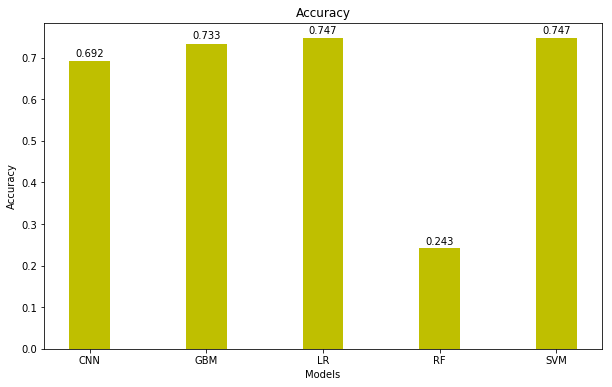

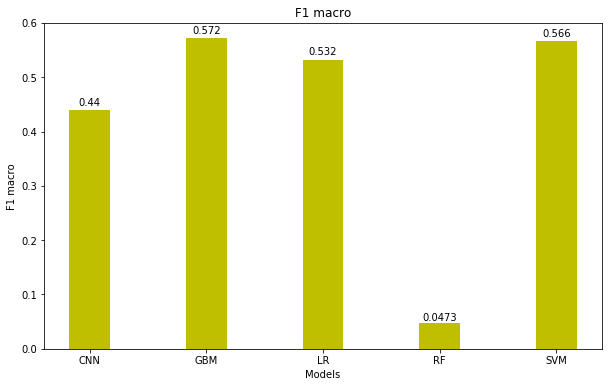

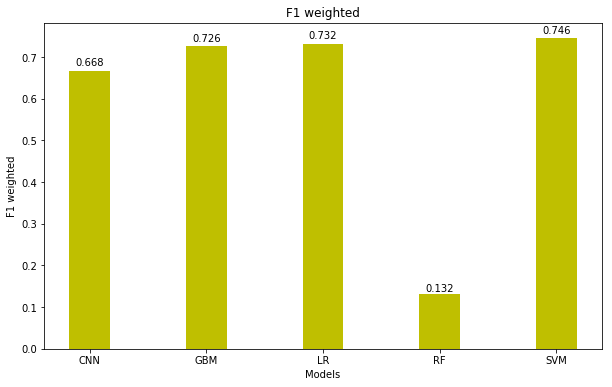

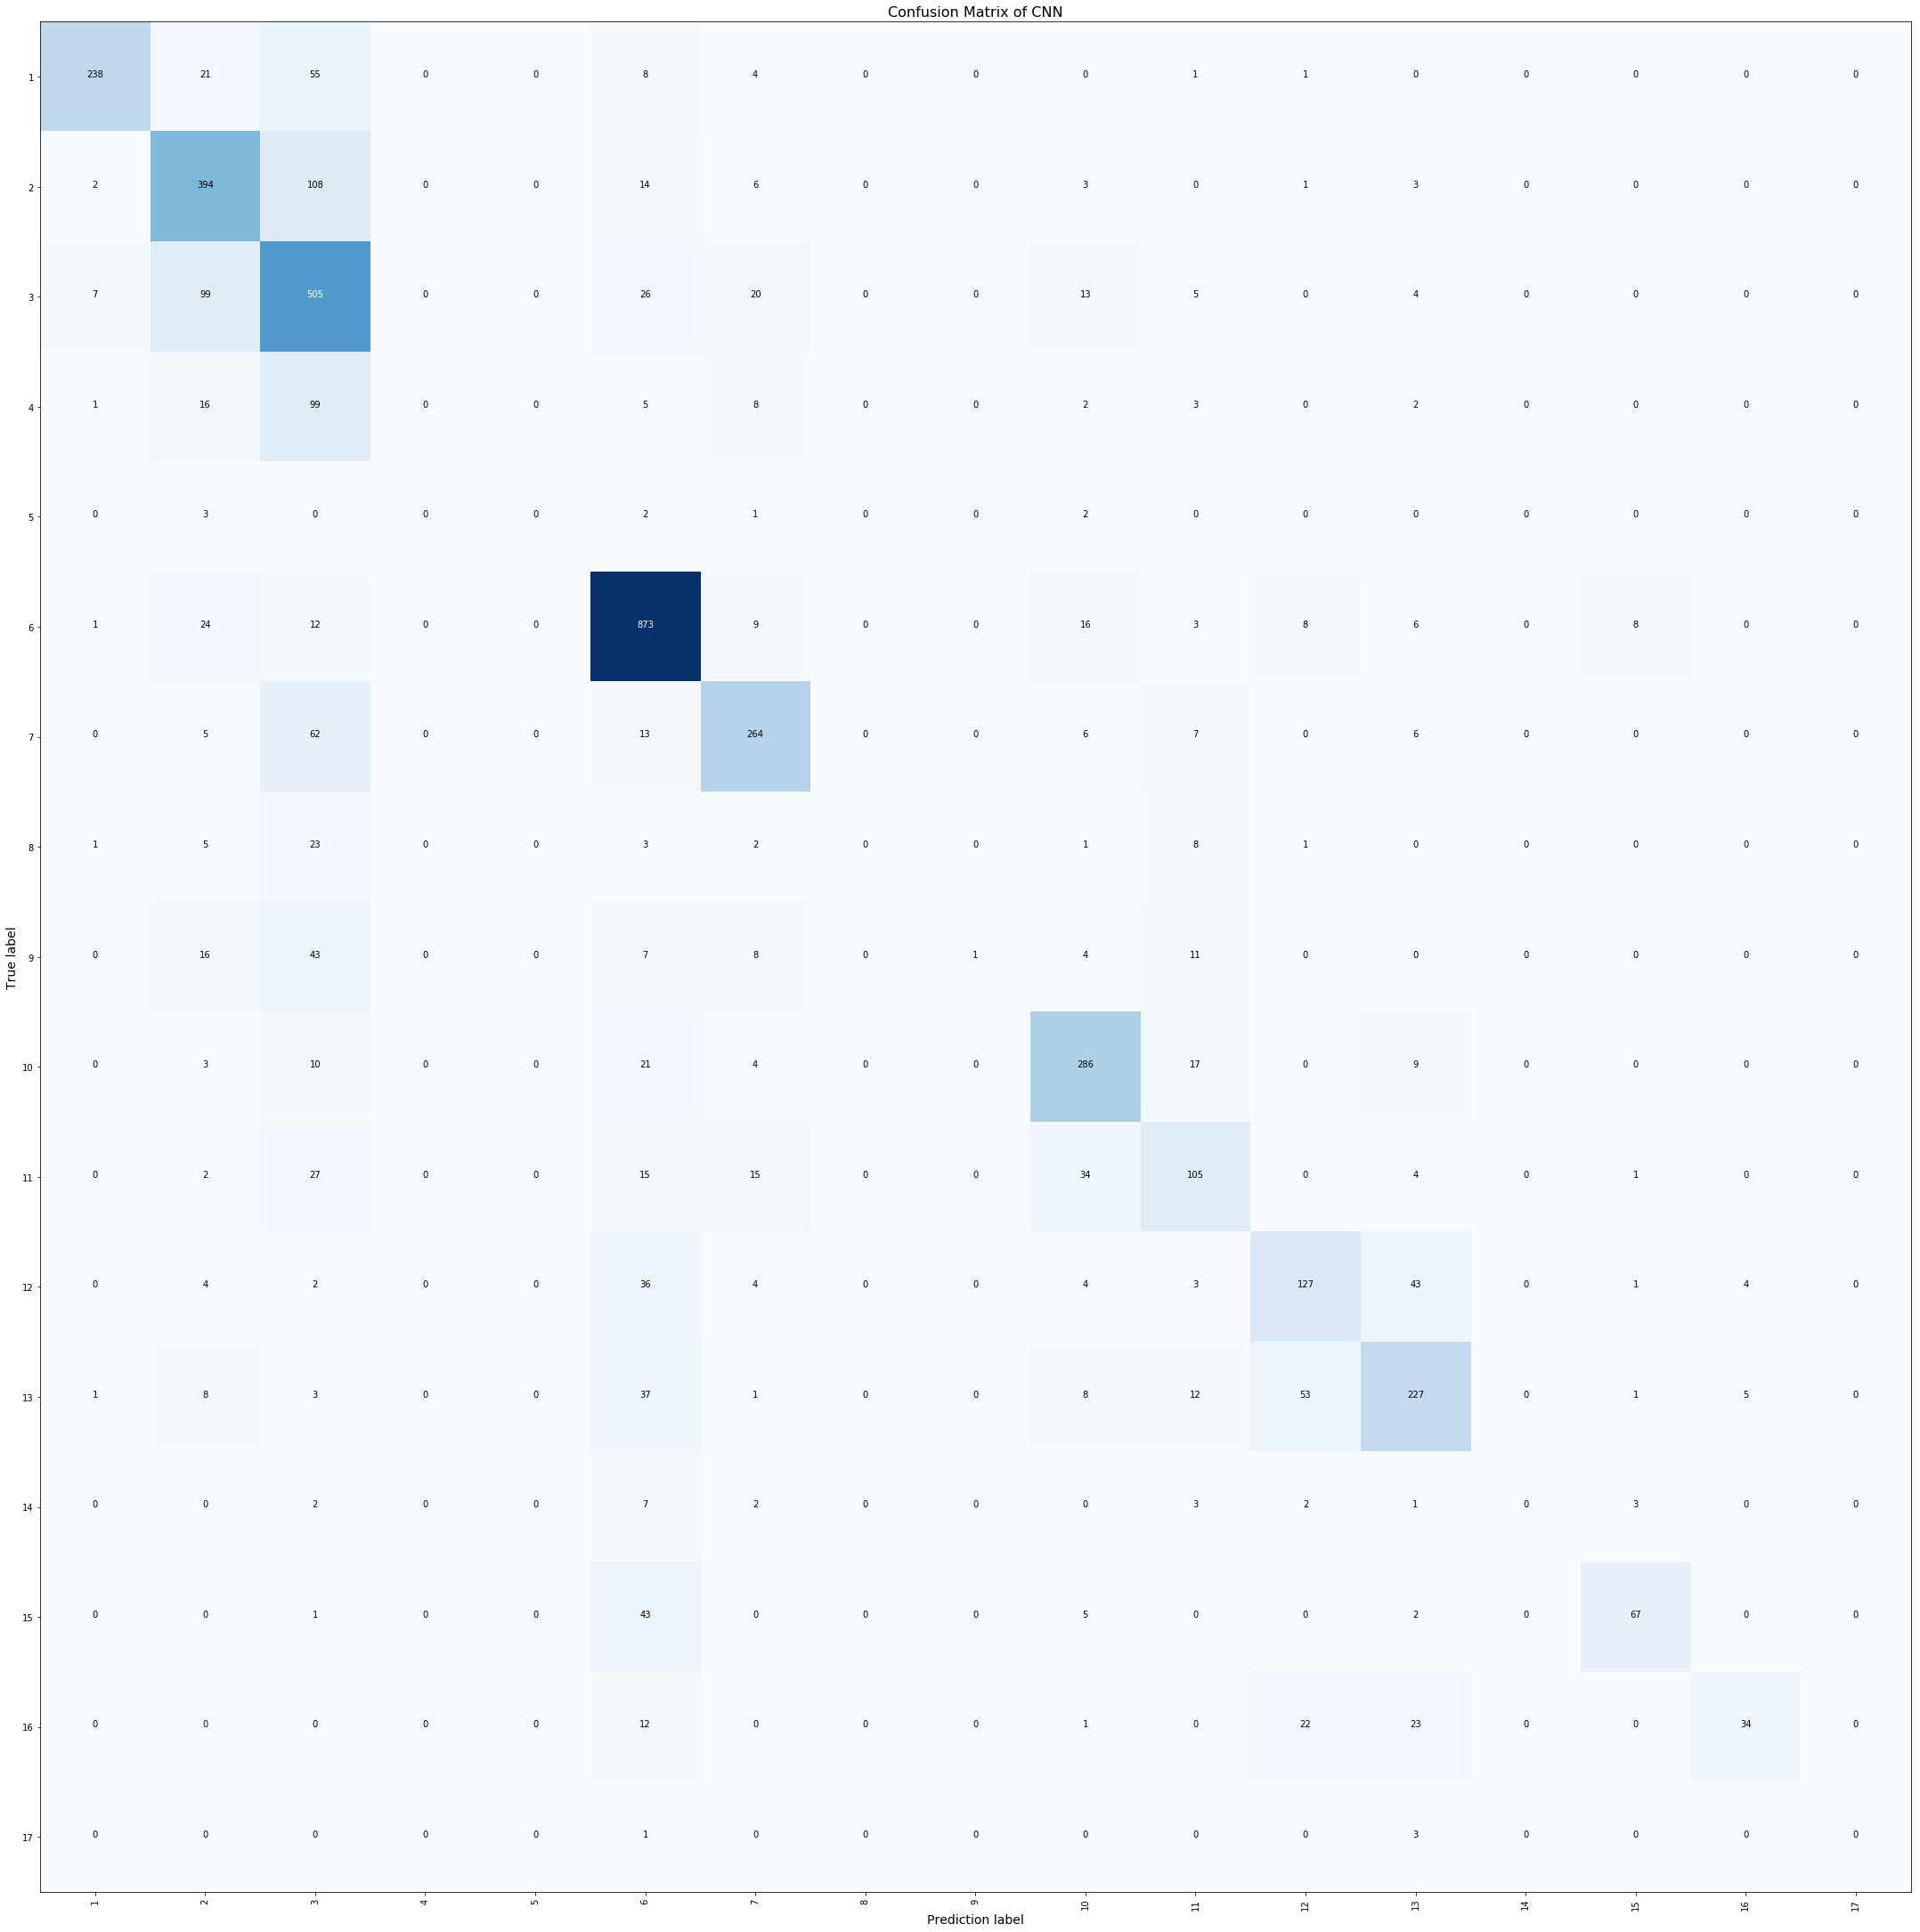

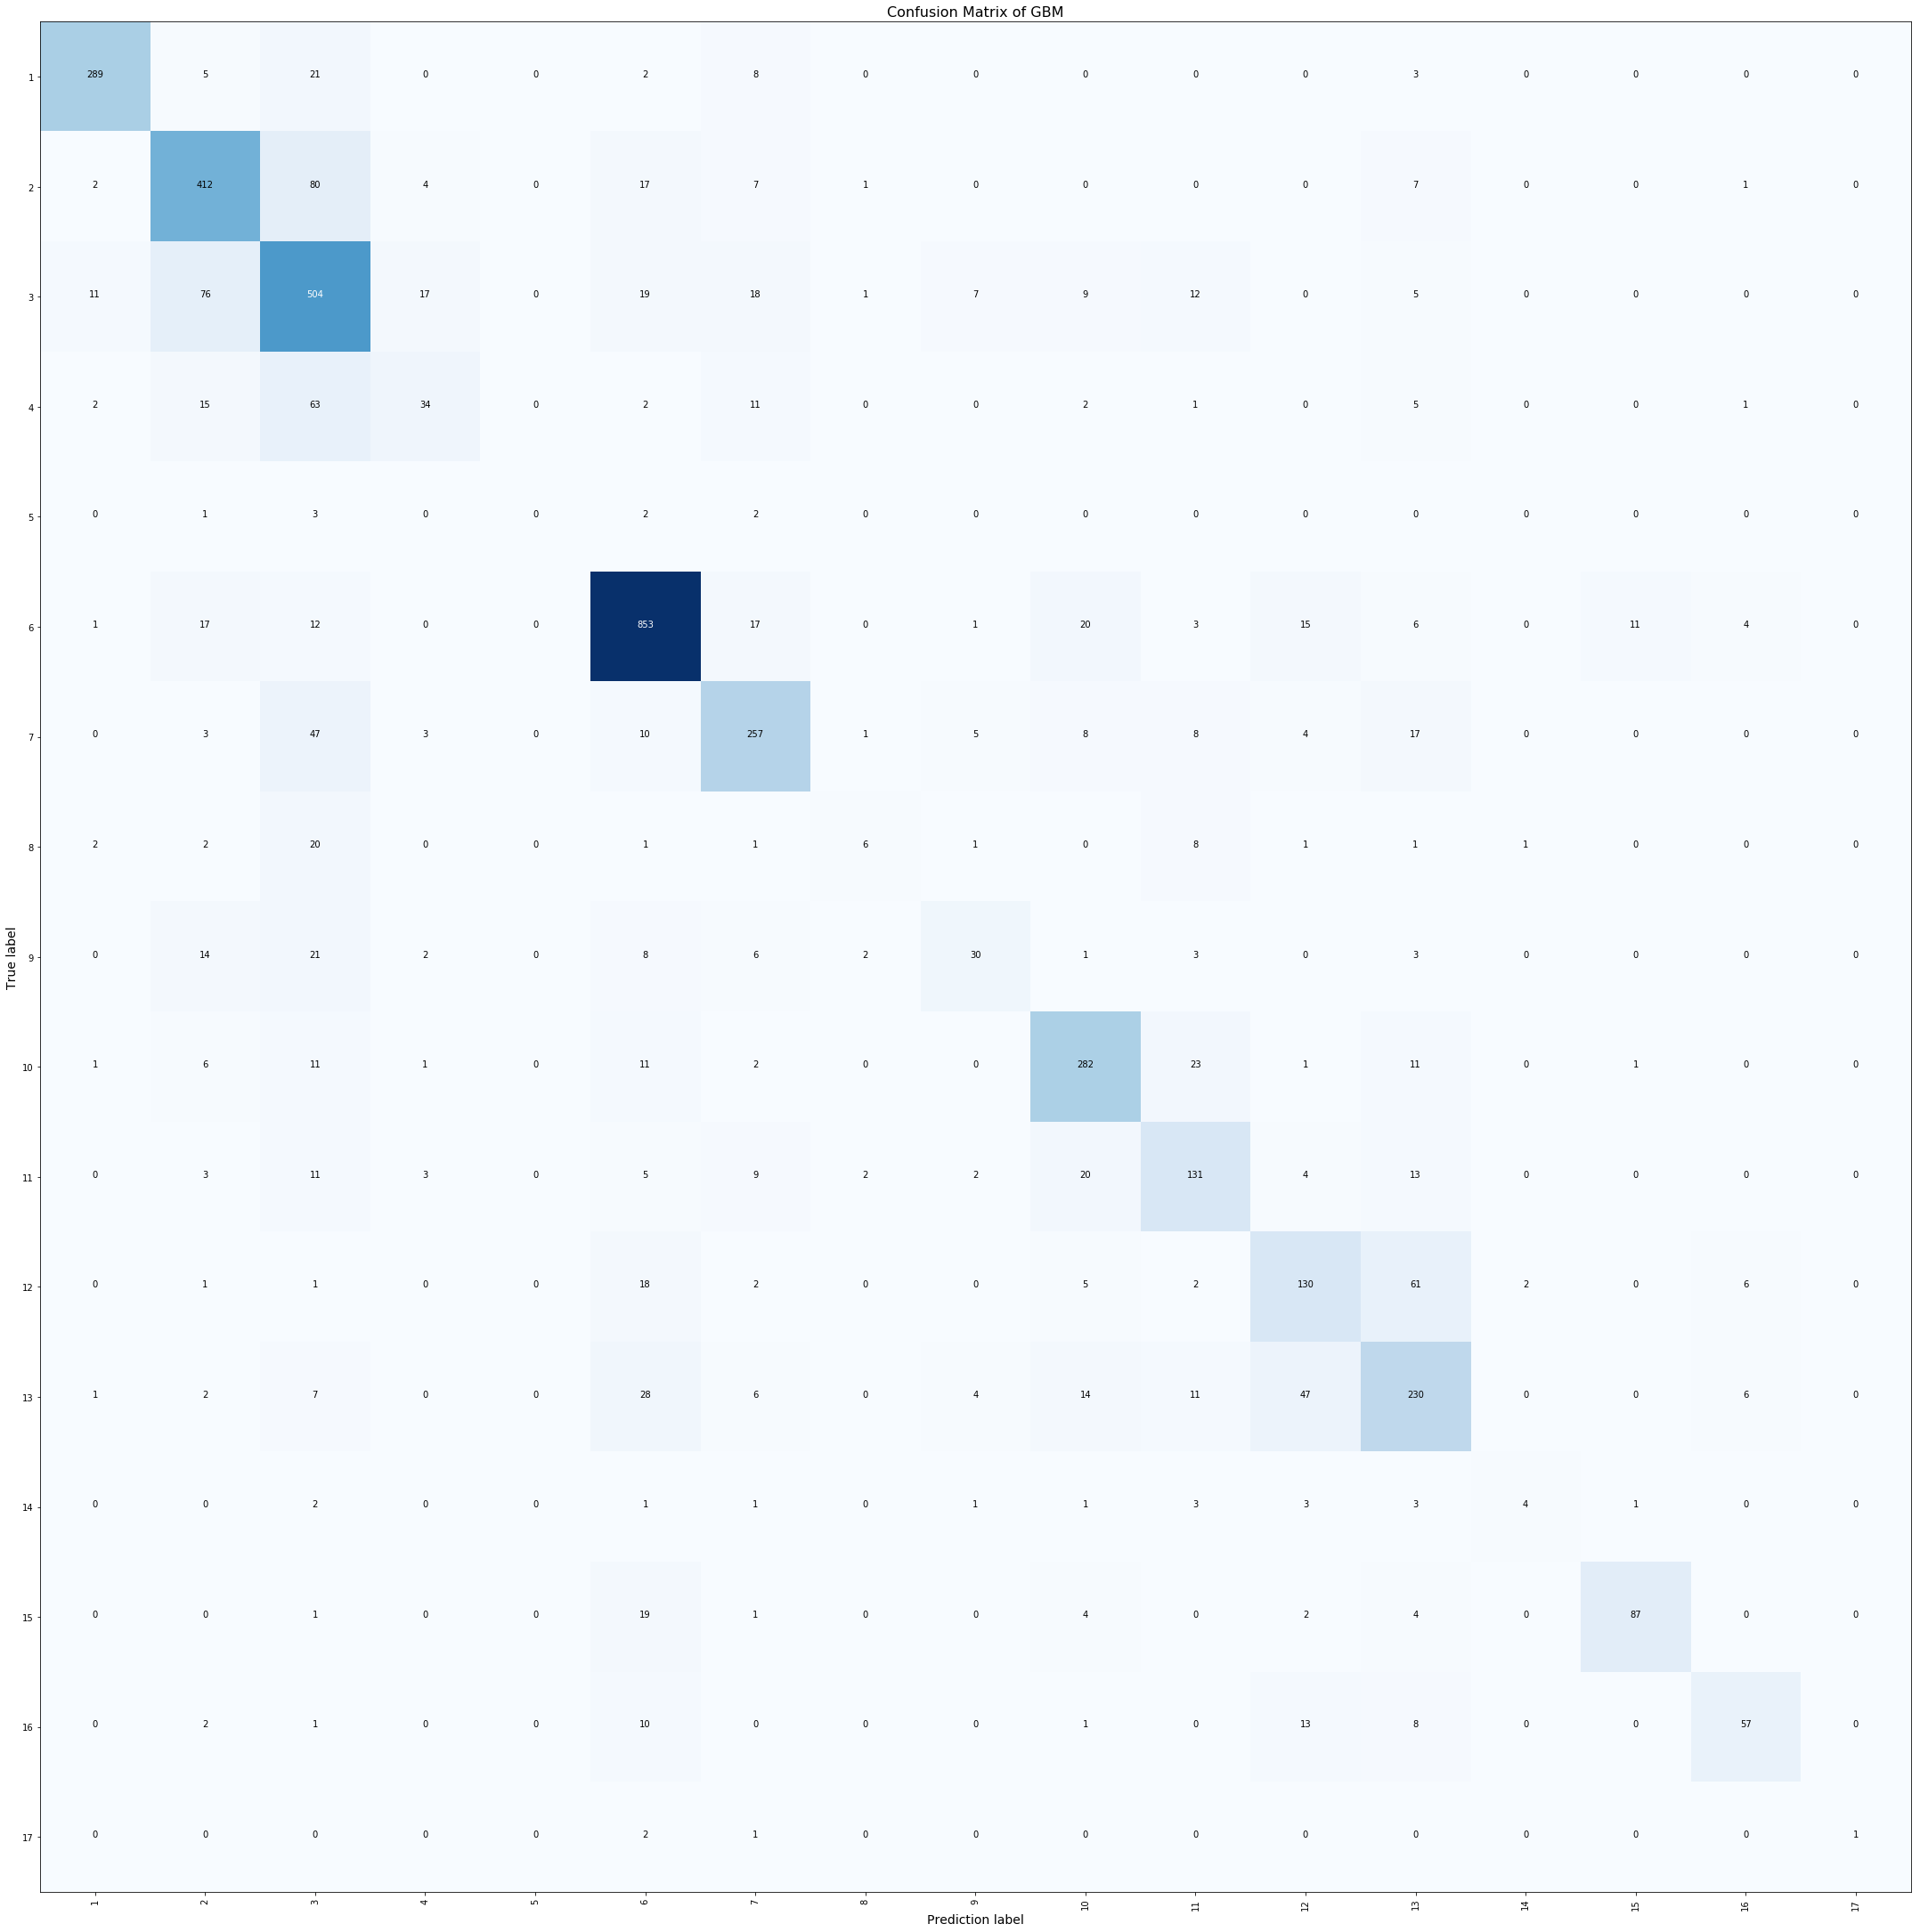

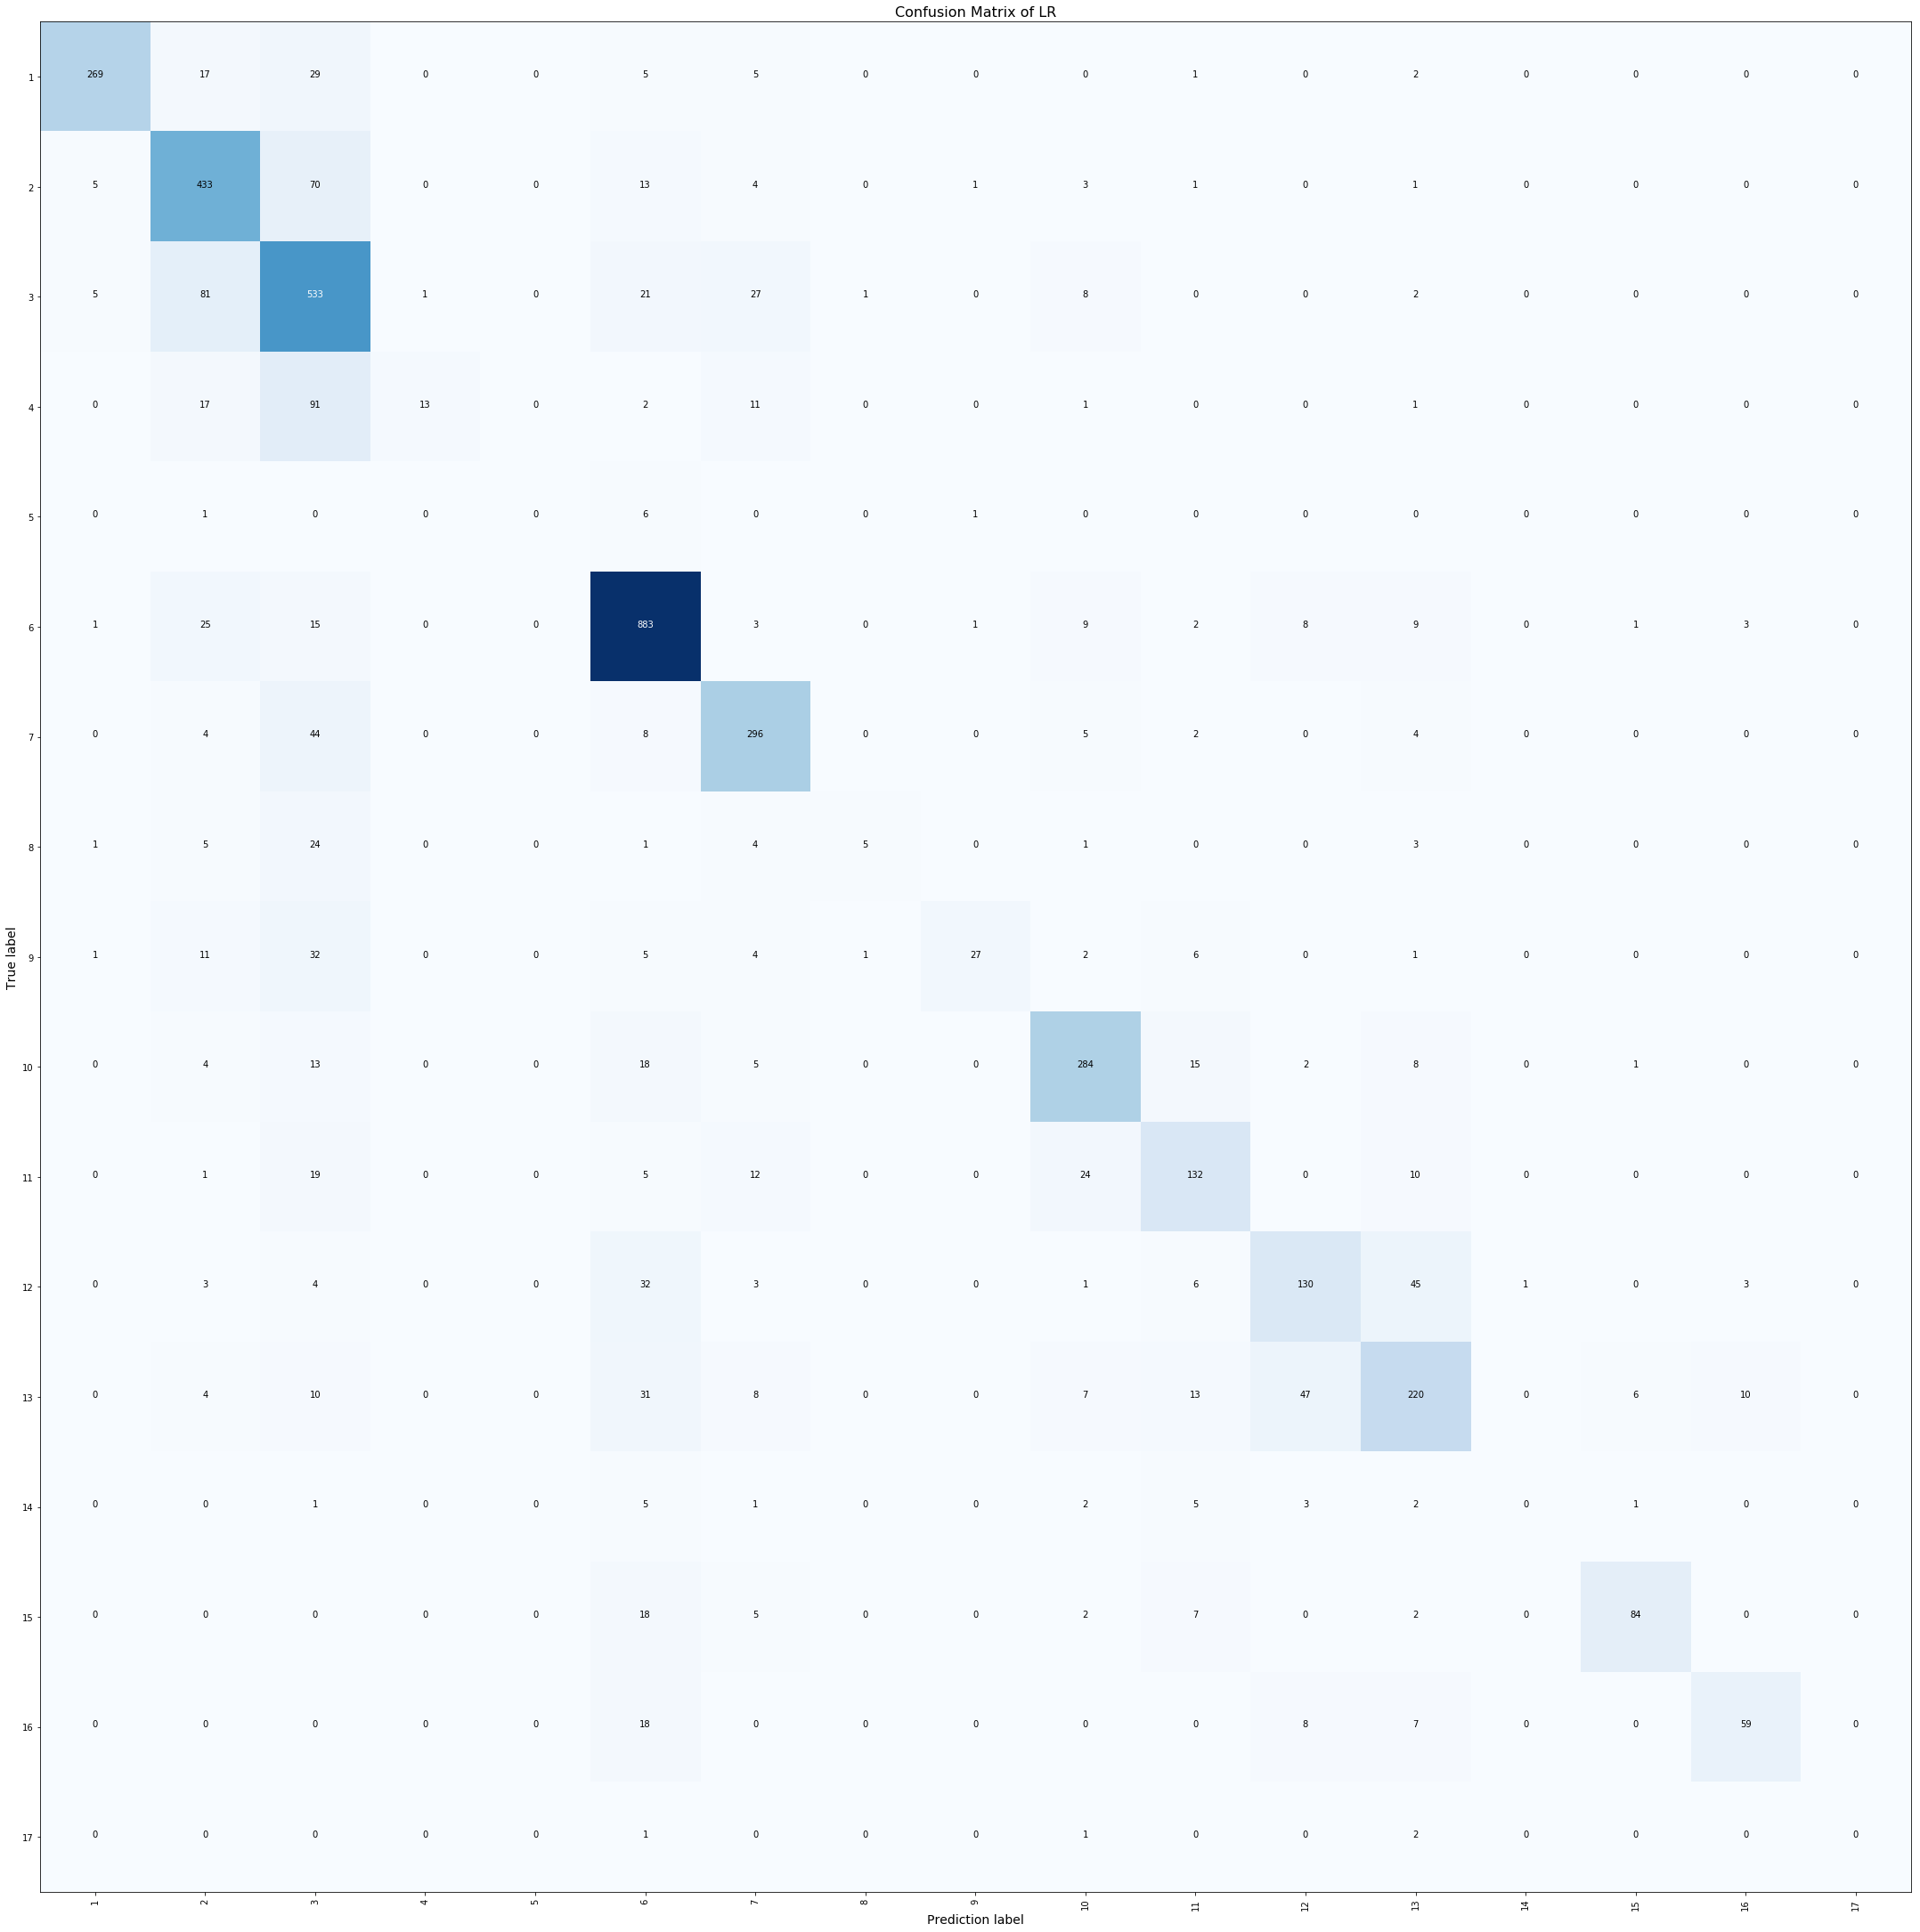

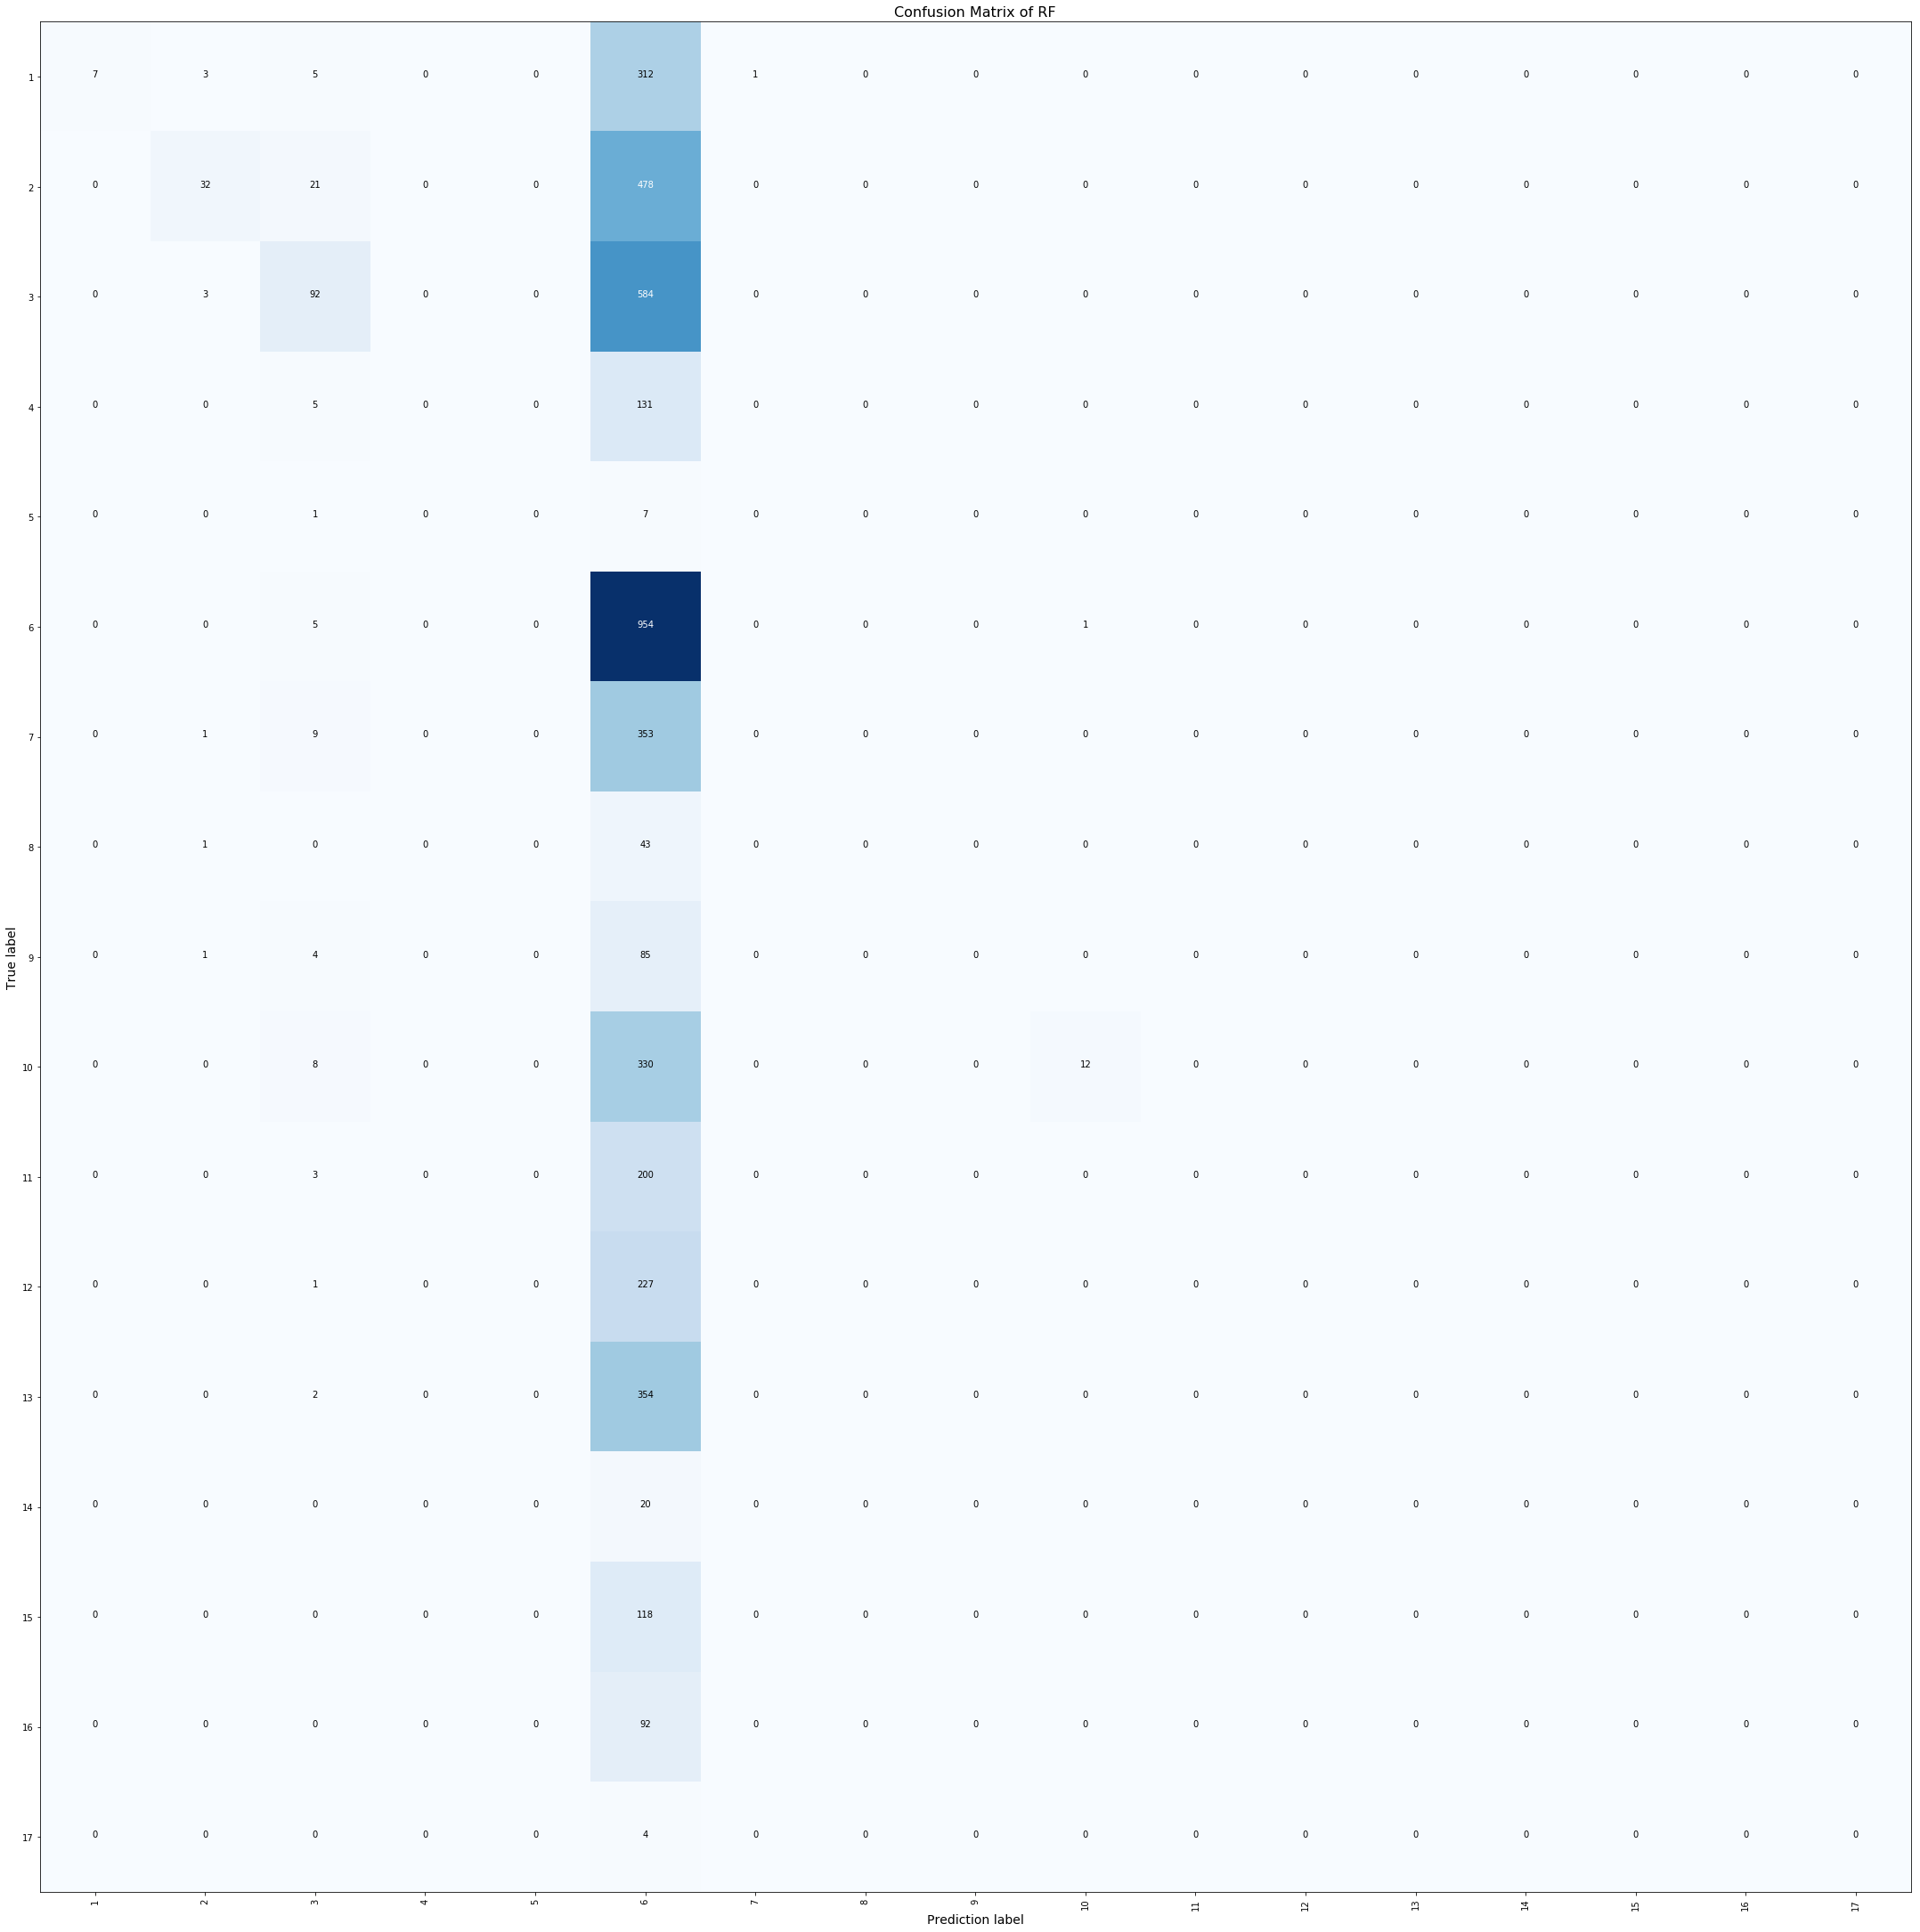

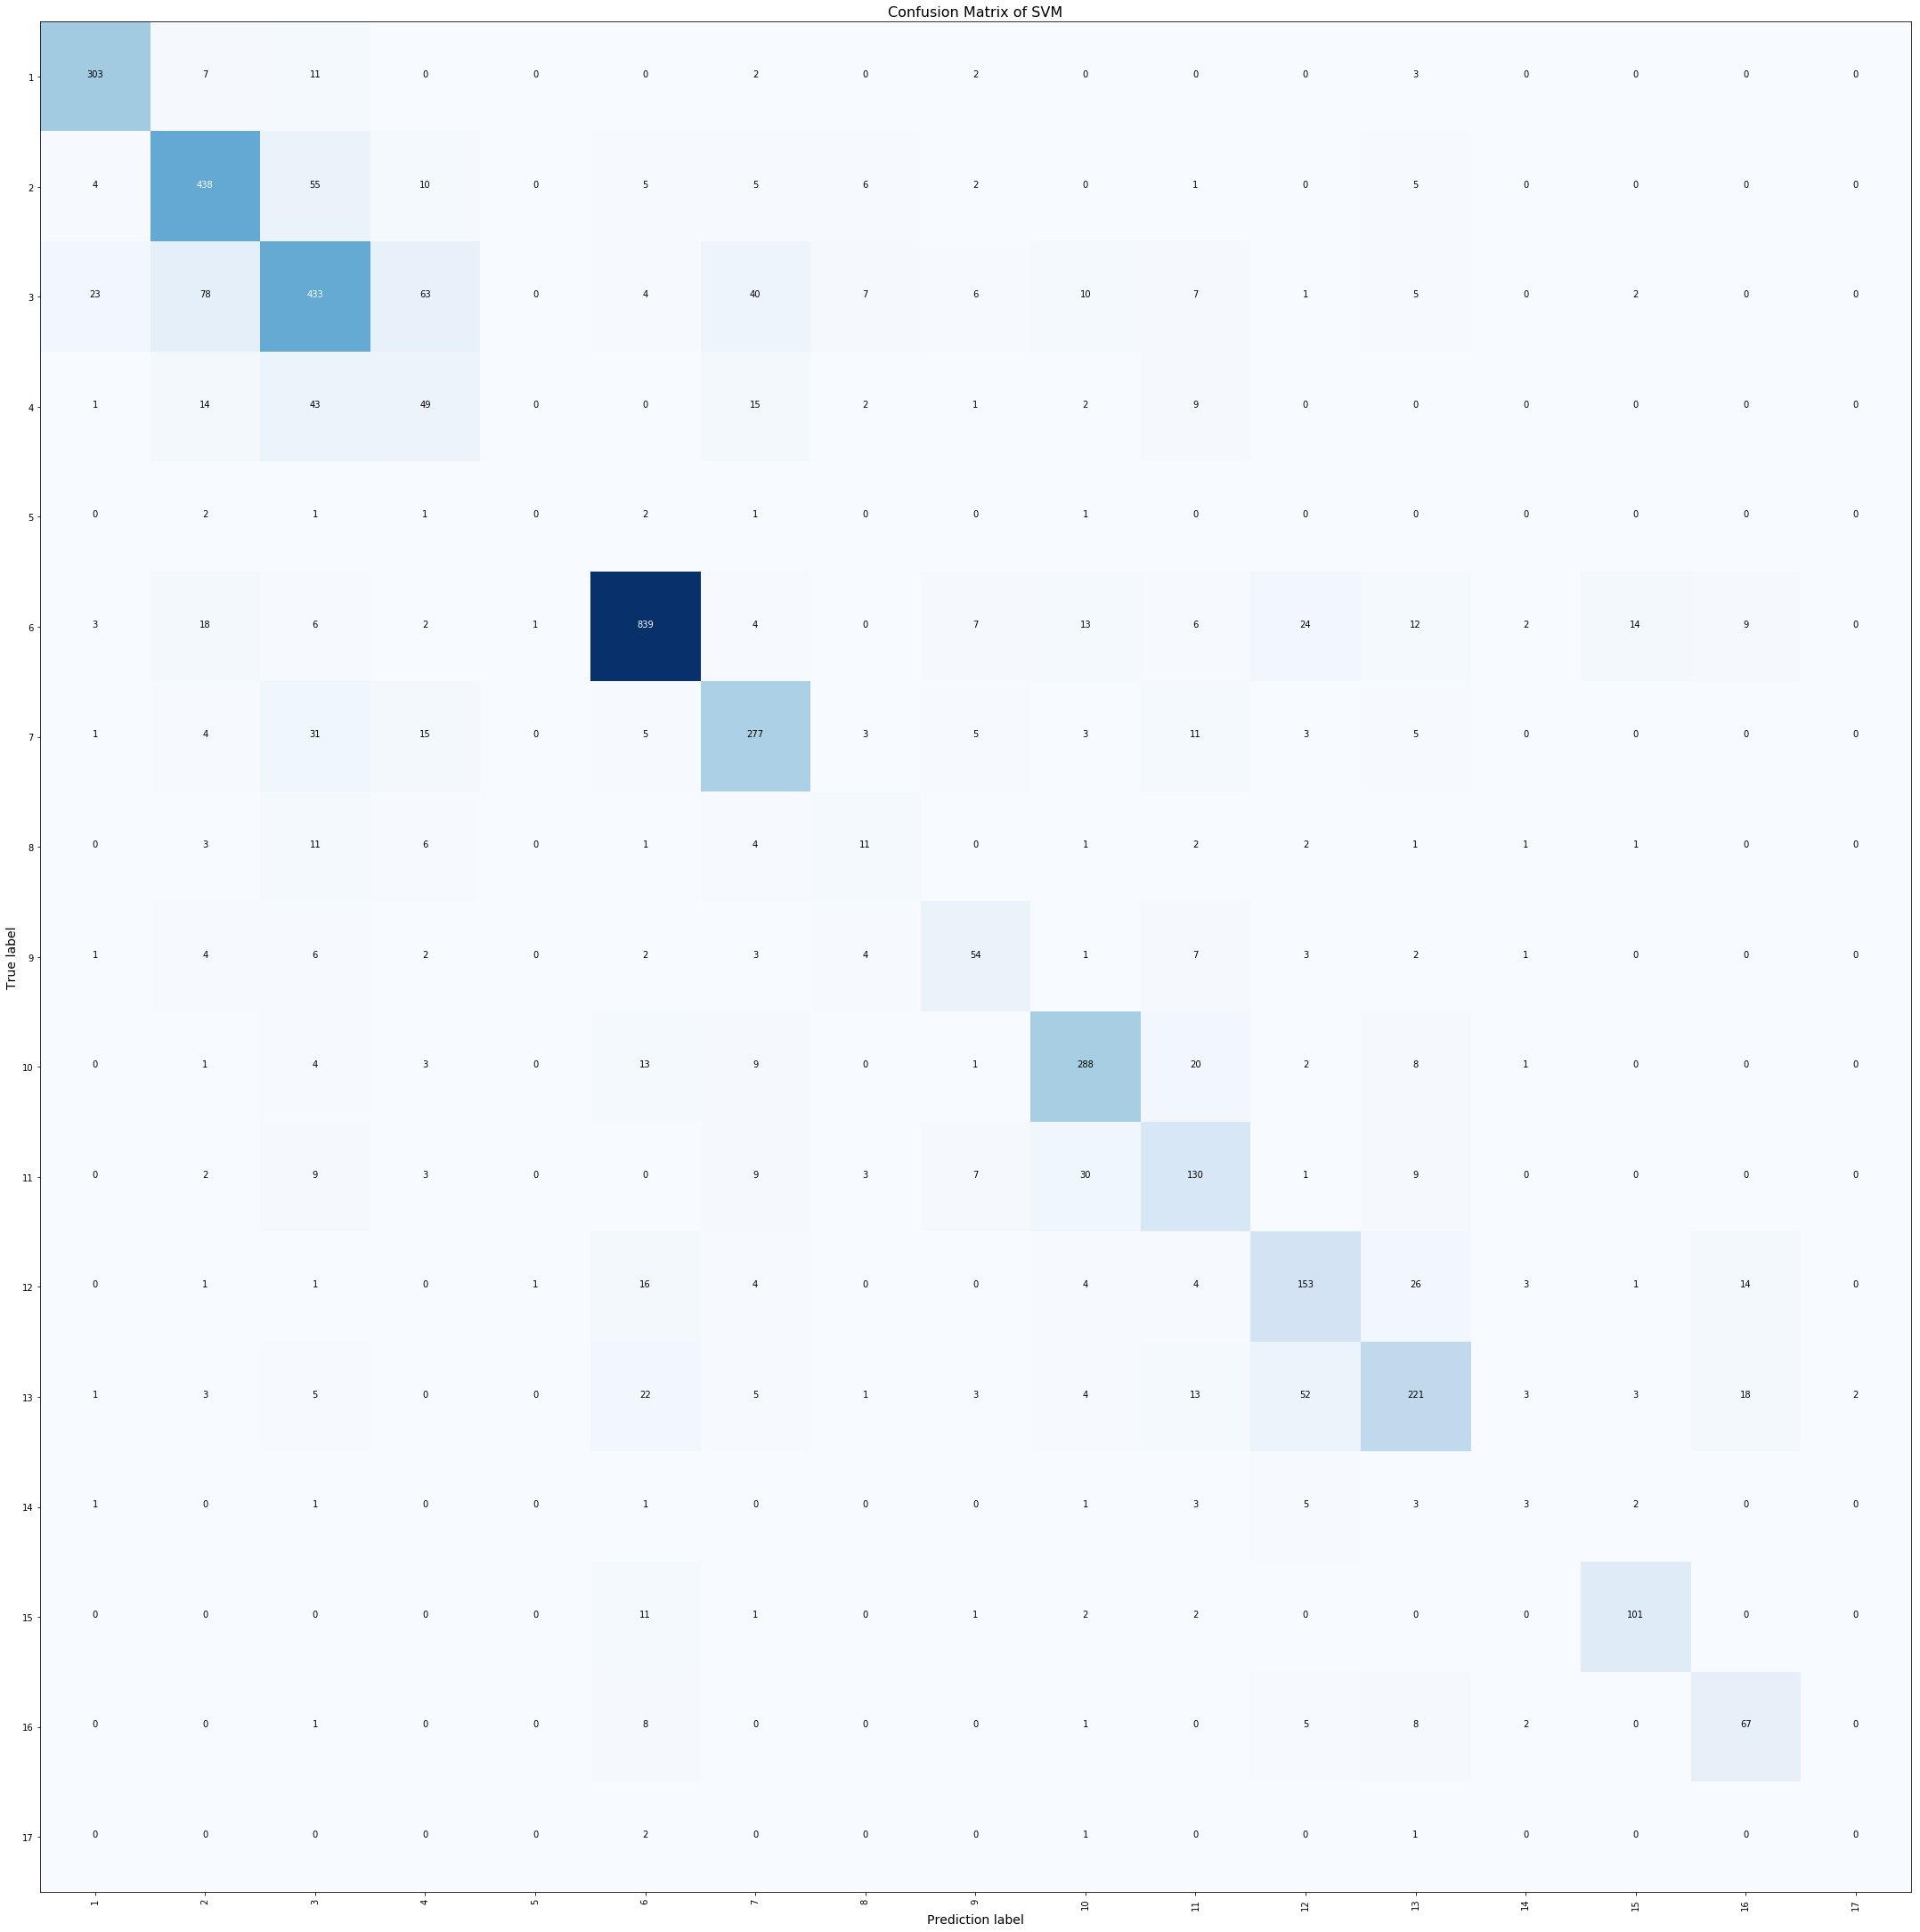

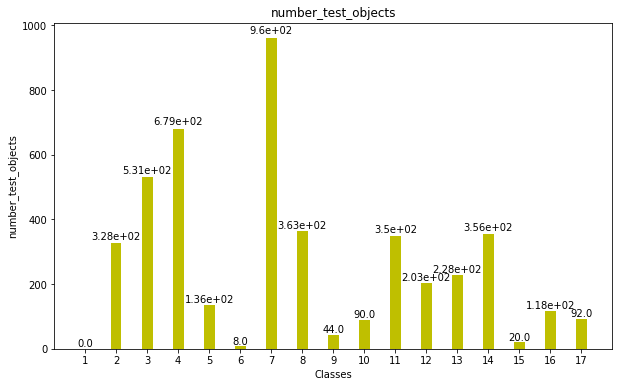

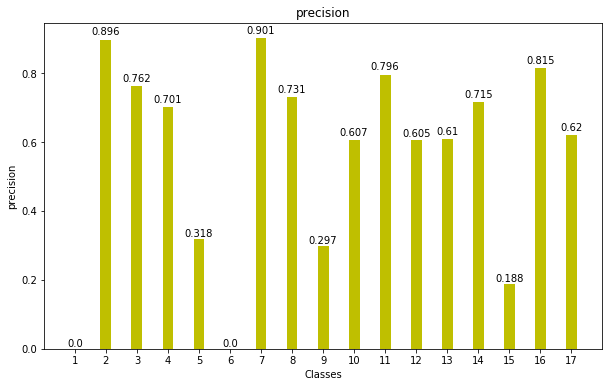

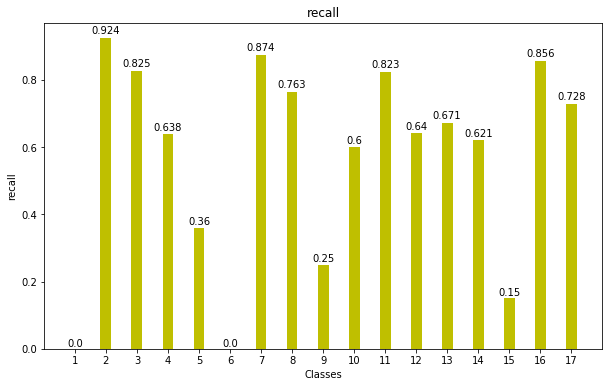

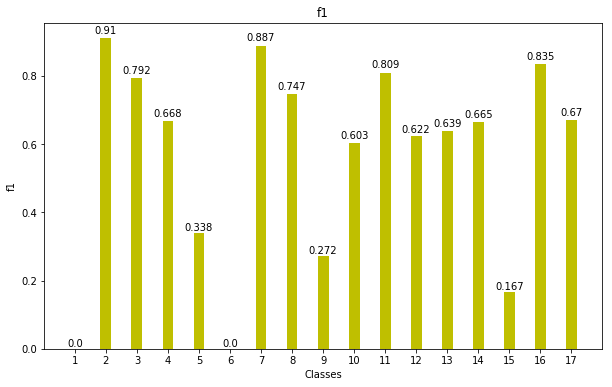

In [346]:
a = results_summarization(date='2018-3-12', path='./debug/results/logs/')

In [219]:
inf = scrab_data('./debug/results/logs/2018-3-12.txt')
table_ = get_table(inf)

In [338]:
a = inf['LR']['list'][0]['results']['classes'].keys()
a

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'])

# Speller

In [3]:
s = 'Мама мыла фаму'

In [4]:
from deeppavlov.core.commands.infer import build_model_from_config

CONFIG_PATH = './DeepPavlov/deeppavlov/configs/error_model/brillmoore_kartaslov_ru.json'

with open(CONFIG_PATH) as config_file:
    config = json.load(config_file)

model = build_model_from_config(config)
print(model([s])[0], flush=True)
# for line in sys.stdin:
#     print(model([line])[0], flush=True)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mks/envs/intent_script/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
2018-03-14 19:42:41.372 INFO in 'deeppavlov.vocabs.typos'['typos'] at line 49: Trying to build a dictionary in /home/mks/projects/intent_classification_script/DeepPavlov/download/russian_words_vocab
2018-03-14 19:42:41.373 INFO in 'deeppavlov.vocabs.typos'['typos'] at line 103: Downloading russian vocab from https://github.com/danakt/russian-words/
2018-03-14 19:42:41.375 DEBUG in 'urllib3.connectionpool'['connectionpool'] at line 824: Starti

мама мыла фому


In [5]:
ln = ['пидр знойный шёл по рульвару', 'ТитаНик ёбнулся пузом об айсберк', 'Иван Ивановиш раотает Тчно']
for x in ln:
    print(model([x])[0], flush=True)

подр знойный шёл по бульвару
титании ёбнулся пузом об айсберг
иван иванович работает тучно


In [14]:
from tqdm import tqdm

class Speller(object):

    def __init__(self, speller_conf=None):
        if speller_conf is None:
            self.conf_path = './DeepPavlov/deeppavlov/configs/error_model/brillmoore_kartaslov_ru.json'
        else:
            self.conf_path = speller_conf

        with open(self.conf_path) as config_file:
            self.config = json.load(config_file)

        self.speller = build_model_from_config(self.config)

    def transform(self, data):
        refactor = list()
        for x in tqdm(data['request']):
            refactor.append(self.speller([x])[0])

        df = pd.DataFrame({'request': refactor,
                           'class': data['class']})

        return df

In [12]:
speller = Speller()

2018-03-14 20:20:31.372 INFO in 'deeppavlov.vocabs.typos'['typos'] at line 76: Loading a dictionary from /home/mks/projects/intent_classification_script/DeepPavlov/download/russian_words_vocab
2018-03-14 20:20:35.750 INFO in 'deeppavlov.models.spellers.error_model.error_model'['error_model'] at line 239: loading error_model from `/home/mks/projects/intent_classification_script/DeepPavlov/download/error_model/error_model_ru.tsv`


In [15]:
dd = speller.transform(dataset.data['test']['base'][0:100])
dd

,class,request
0,16,привязали чек к карте
1,6,здравствуйте у меня аналогичная ситуация с пен...
2,3,купила говяжий фарш в магазине вкус свил безоб...
3,10,как не приду в магазин не могу купить филе гру...
4,6,хлебцы ржаною отрубные у одних дата пр ва 25 1...
5,6,в магазине 912м грузинский8 место выкладки теп...
6,6,в магазине 1267м жел привокзальная место выкла...
7,10,а в электросталь так и не завезли
8,6,на профсоюзной 104 paypass не работает хотя те...
9,11,а щавель и крапива могут попасть на прилавок в...
